In [287]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [288]:
pd.options.display.max_columns = 100

In [289]:
df_store = pd.read_csv('/content/stores.csv')

In [290]:
df_train = pd.read_csv('/content/train.csv')

In [291]:
df_features = pd.read_csv('/content/features.csv')

## Merging 3 Dataframes

In [292]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [293]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [294]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [295]:
# merging 3 different sets

df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [296]:
df.drop(['IsHoliday_y'], axis=1, inplace=True)

In [297]:
df.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

In [298]:
df.head() # last ready dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [299]:
df.shape

(421570, 16)

## Store & Department Numbers

In [300]:
df['Store'].nunique() # number of different values

45

In [301]:
df['Dept'].nunique() # number of different values

81

In [302]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept', values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

Store numbers begin from 1 to 45, department numbers are from 1 to 99, but some numbers are missing such as there is no 88 or 89 etc. Total number of departments is 81.

From the pivot table, it is obviously seen that there are some wrong values such as there are 0 and minus values for weekly sales. But sales amount can not be minus. Also, it is impossible for one department not to sell anything whole week. So, I will change this values.

In [303]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,11436.22,245.0,6.85,6964.26,4836.22,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,21290.13,NaN,69.89,4977.35,3261.04,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221


In [304]:
df = df.loc[df['Weekly_Sales']>0]

In [305]:
df.shape # new data shape

(420212, 16)

## Date

In [306]:
pd.concat([df['Date'].head(5), df['Date'].tail(5)]) # to see first and last 5 rows.

,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
421565,2012-09-28
421566,2012-10-05
421567,2012-10-12
421568,2012-10-19
421569,2012-10-26


## IsHoliday Column

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

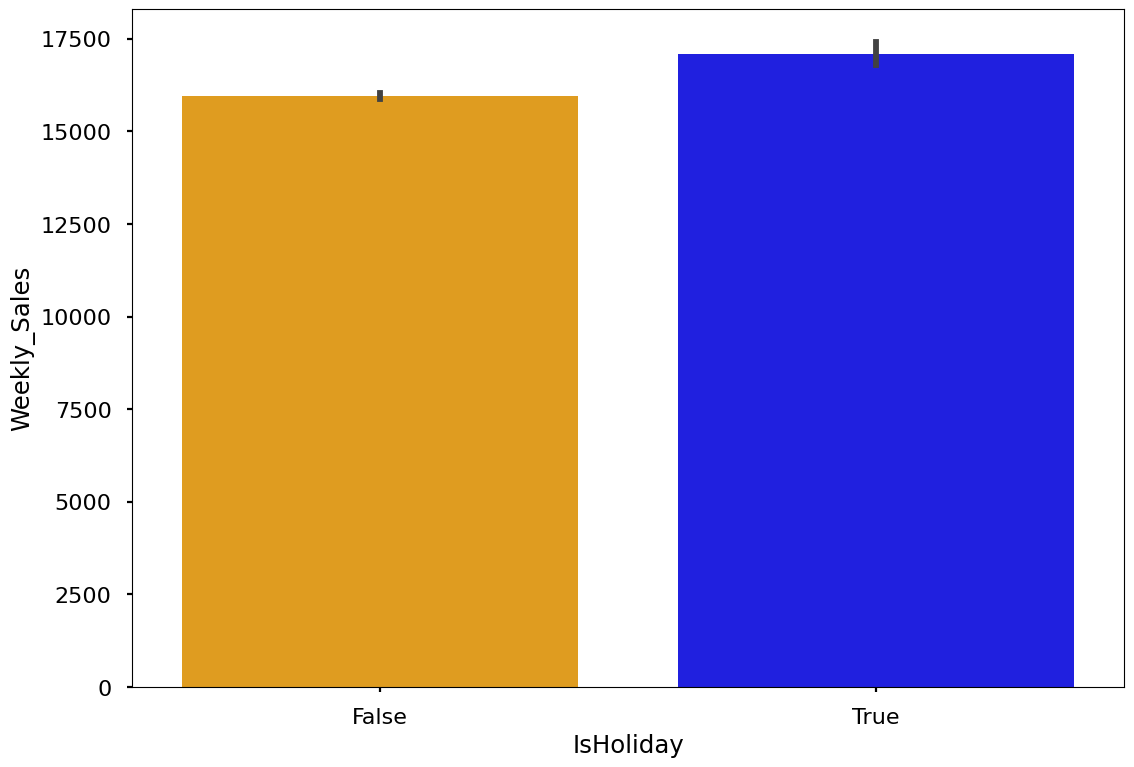

In [307]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df, palette=['orange', 'blue'])

In [308]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [309]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [310]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [311]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [312]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [313]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

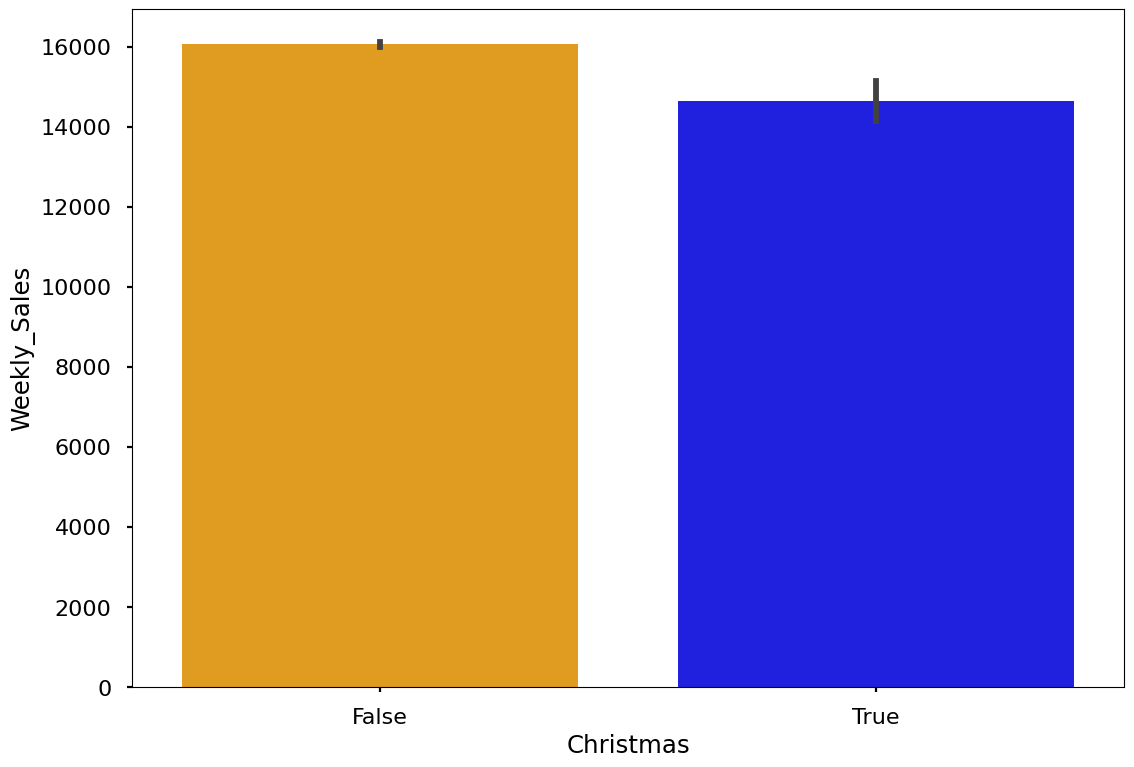

In [314]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df, palette=['orange', 'blue']) # Christmas holiday vs not-Christmas

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

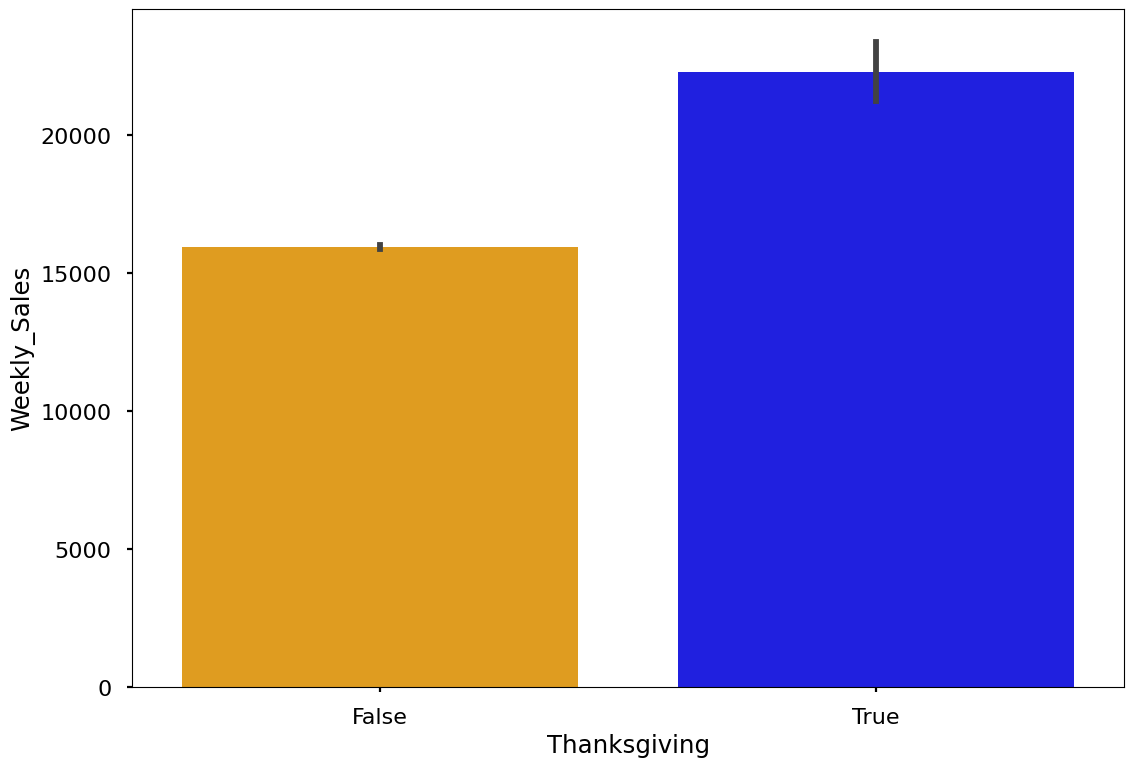

In [315]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df, palette=['orange', 'blue']) # Thanksgiving holiday vs not-Thanksgiving

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

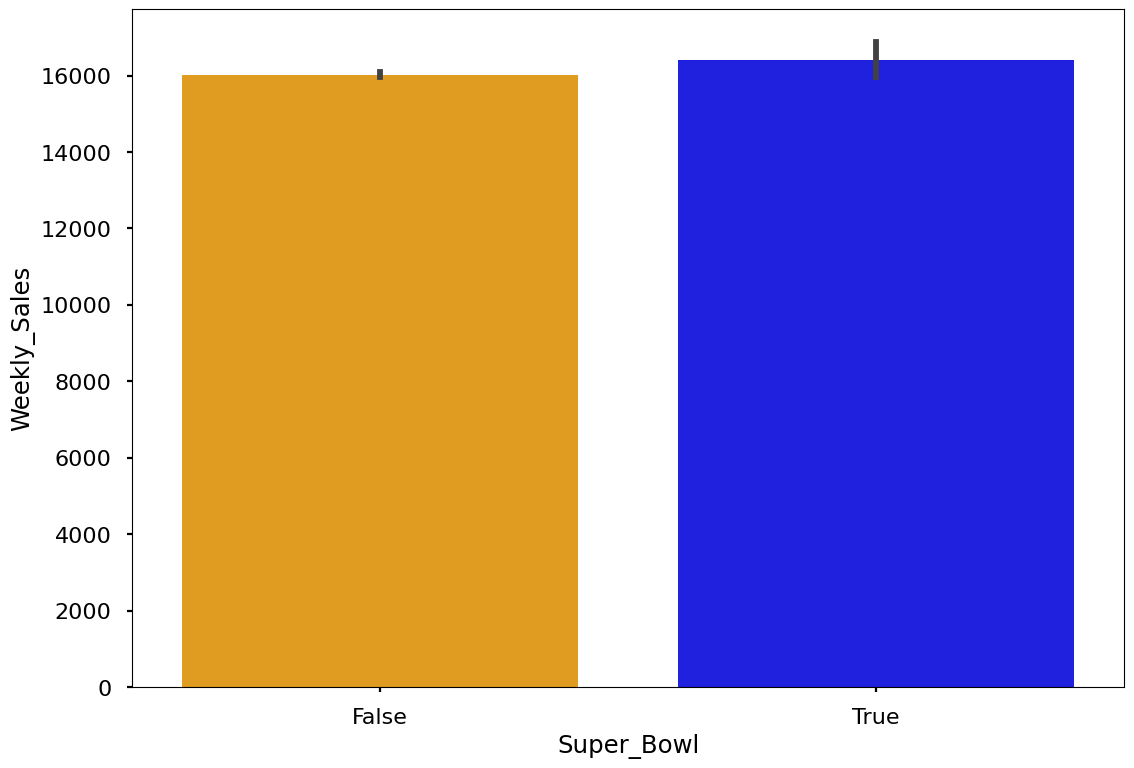

In [316]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df, palette=['orange', 'blue']) # Superbowl holiday vs not-Superbowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

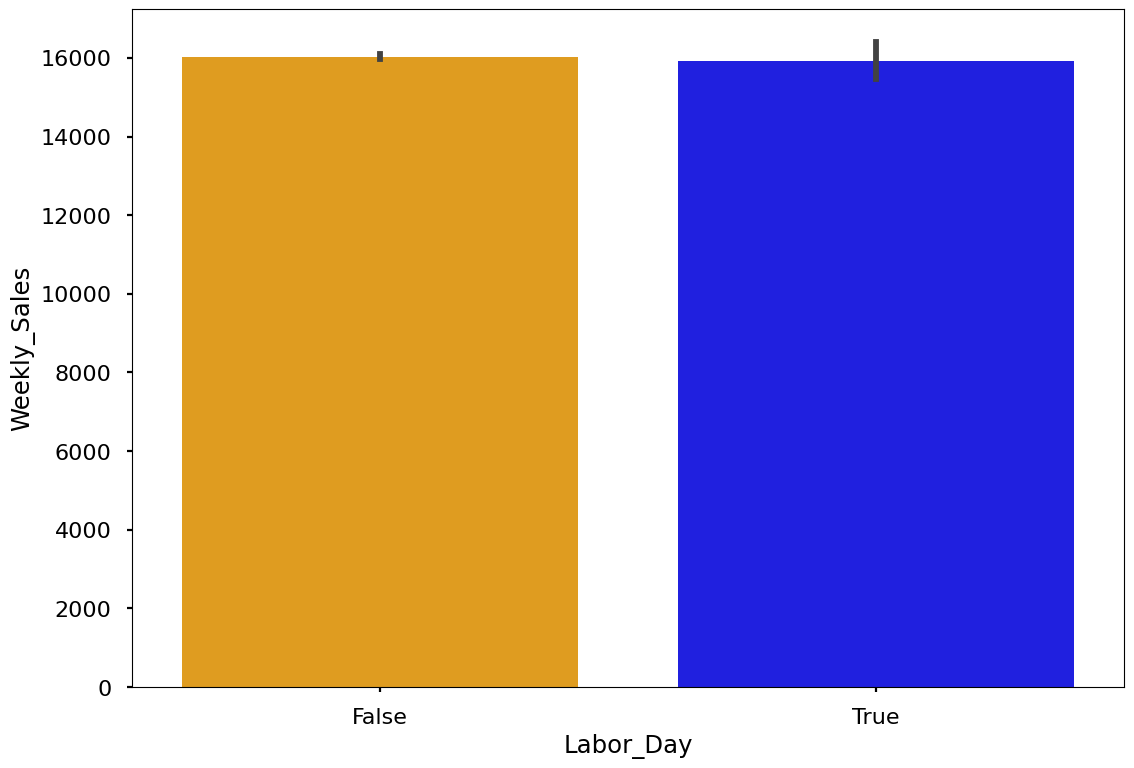

In [317]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df, palette=['orange', 'blue']) # Labor day holiday vs not-Labor day

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

## Type Effect on Holidays

There are three different store types in the data as A, B and C.

In [318]:
df.groupby(['Christmas', 'Type'])['Weekly_Sales'].mean() # Avg weekly sales for types on Christmas

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [319]:
df.groupby(['Thanksgiving', 'Type'])['Weekly_Sales'].mean() # Avg weekly sales for types on Thanksgiving

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [320]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Labor Day

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [321]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Super Bowl

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

## Percentages of store types

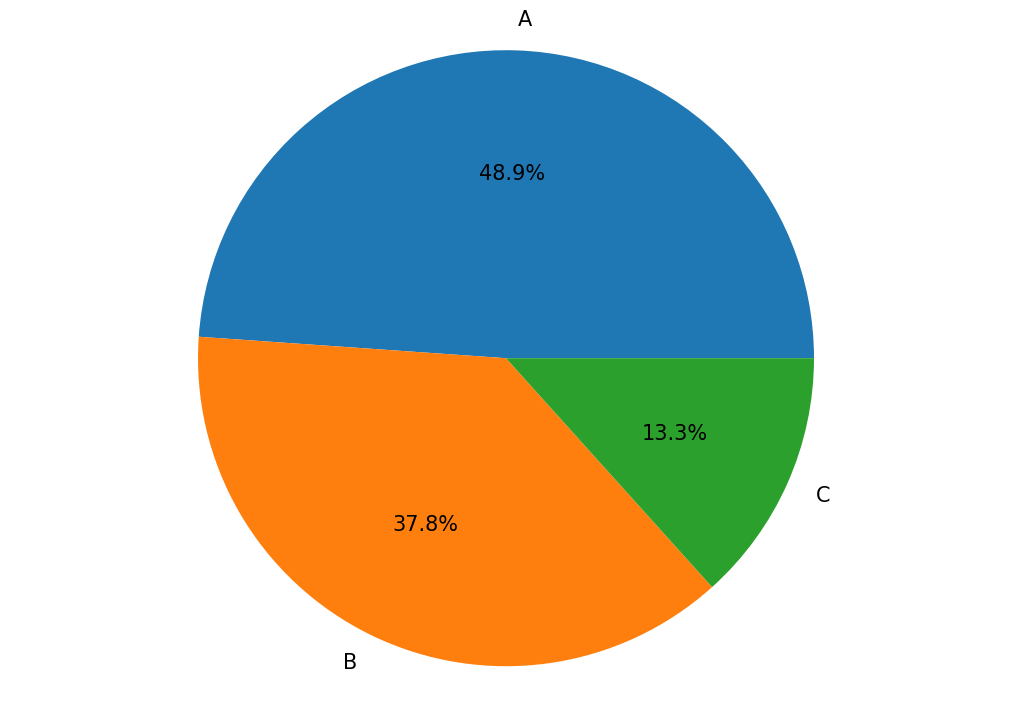

In [322]:
my_data = [48.88, 37.77 , 13.33 ]  #percentages
my_labels = ['A', 'B', 'C']
plt.pie(my_data, labels=my_labels, autopct='%1.1f%%', textprops={'fontsize': 15})
plt.axis('equal')
mpl.rcParams.update({'font.size':20})
plt.show()

In [323]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

,Weekly_Sales
IsHoliday,
False,15952.816352
True,17094.300918


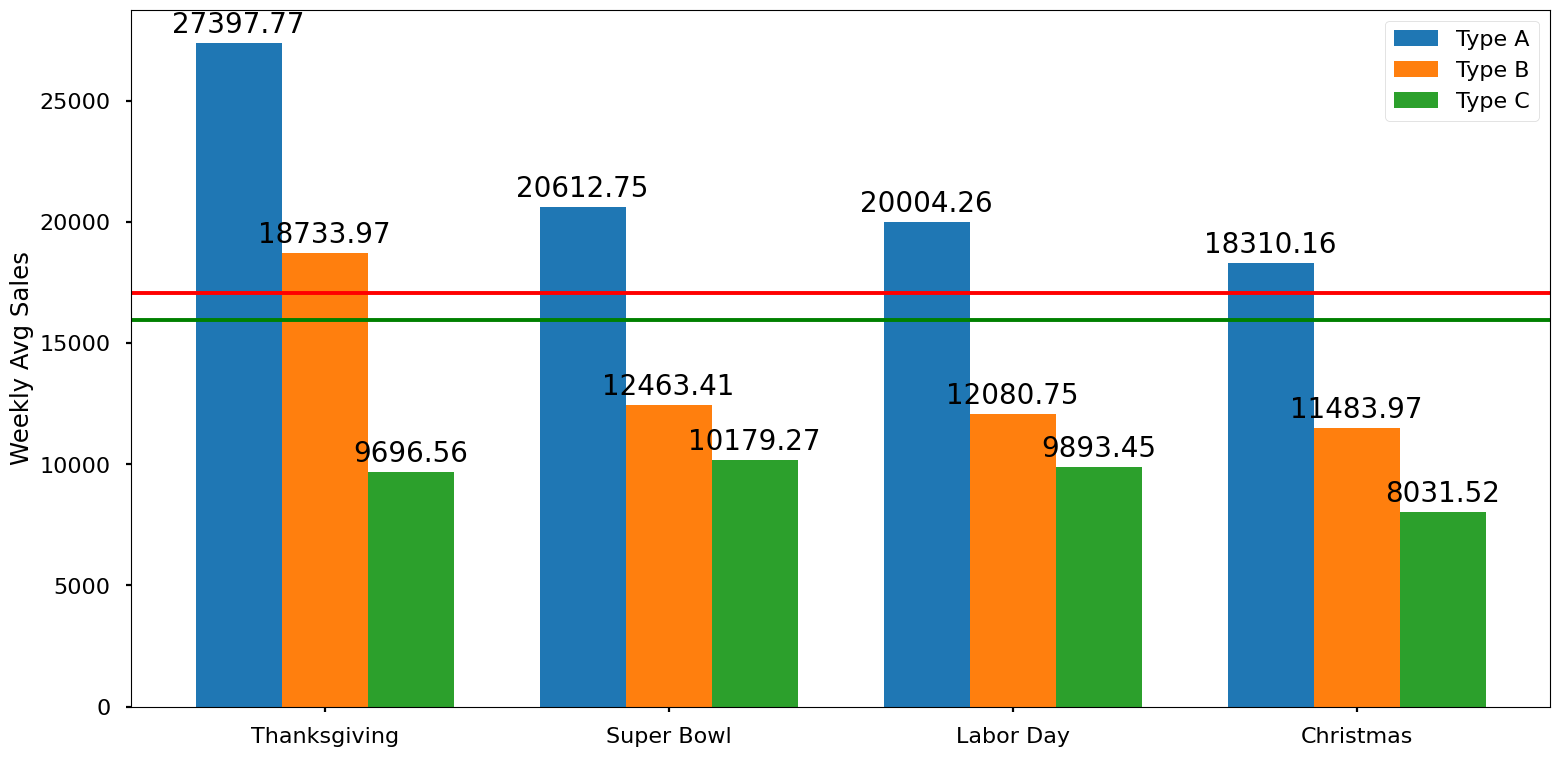

In [324]:
# Plotting avg weekly sales according to holidays by types
plt.style.use('seaborn-v0_8-poster')
labels = ['Thanksgiving', 'Super Bowl', 'Labor Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels)) # label location
width = 0.25 # width of bars
1
fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width, A_means, width, label='Type A')
rects2 = ax.bar(x, B_means, width, label='Type B')
rects3 = ax.bar(x + width, C_means, width, label='Type C')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holiday avg
plt.axhline(y=15952.82,color='green') # non-holiday avg

fig.tight_layout()

plt.show()


It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [325]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
95373,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
338013,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
95425,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
337961,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
135665,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


## To See the Size - Type Relation

In [326]:
df_store.groupby('Type').describe()['Size'].round(2)

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


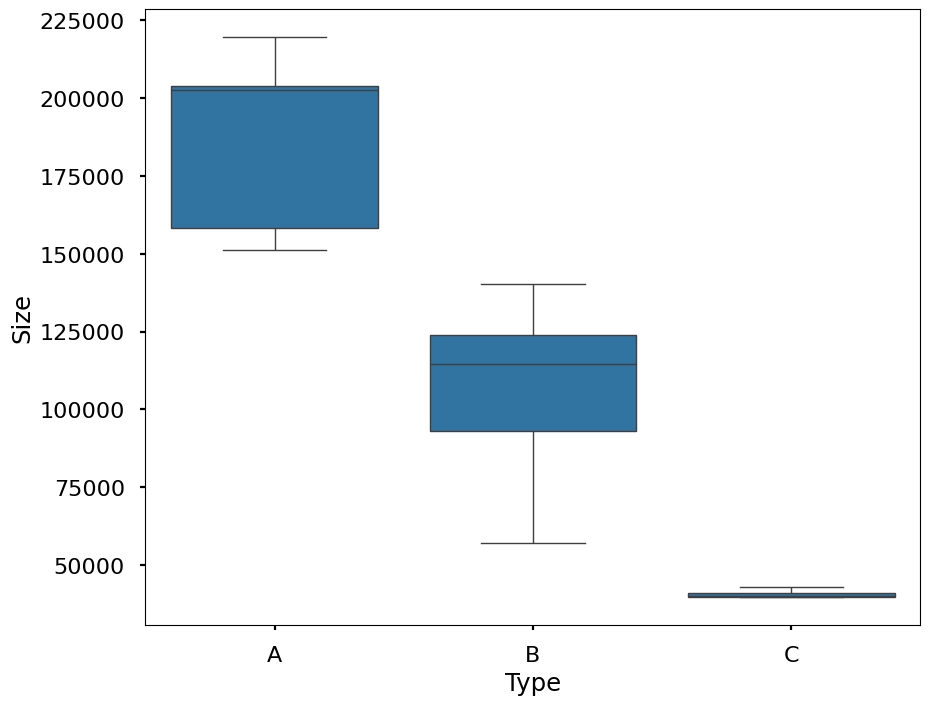

In [327]:
plt.figure(figsize=(10,8))
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

## Markdown Columns

To handle the missing values in the markdown columns, the NaN values can be replaced with 0. Since the presence of a number in these columns indicates a markdown, replacing NaN with 0 will signify that no markdown occurred on that date.

In [328]:
df.isna().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,270031
MarkDown2,309308
MarkDown3,283561


In [329]:
df = df.fillna(0) # filling null's with 0

In [330]:
df.isna().sum() # last null check

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0
MarkDown3,0


In [331]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


The minimum value for weekly sales is 0.01, which is likely not accurate. However, it will not be adjusted at this point. Given the complexity of checking each department across all stores (45 stores and 81 departments), addressing each instance would be time-consuming. Instead, the focus will be on using averages for exploratory data analysis (EDA) to identify broader trends.

## Deeper looks in Sales

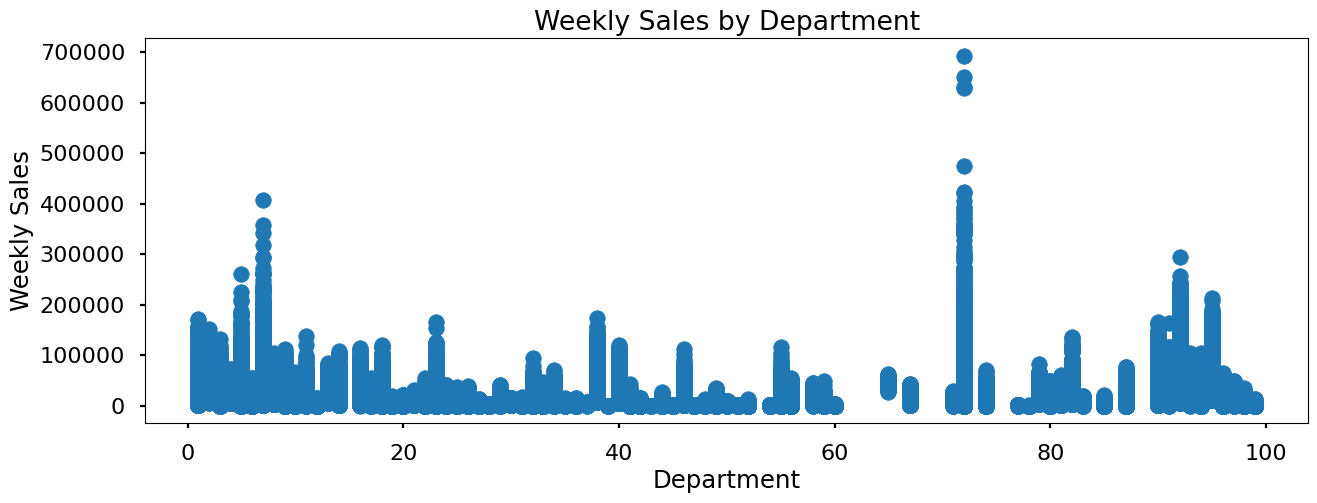

In [332]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.scatter(x, y)
plt.show()

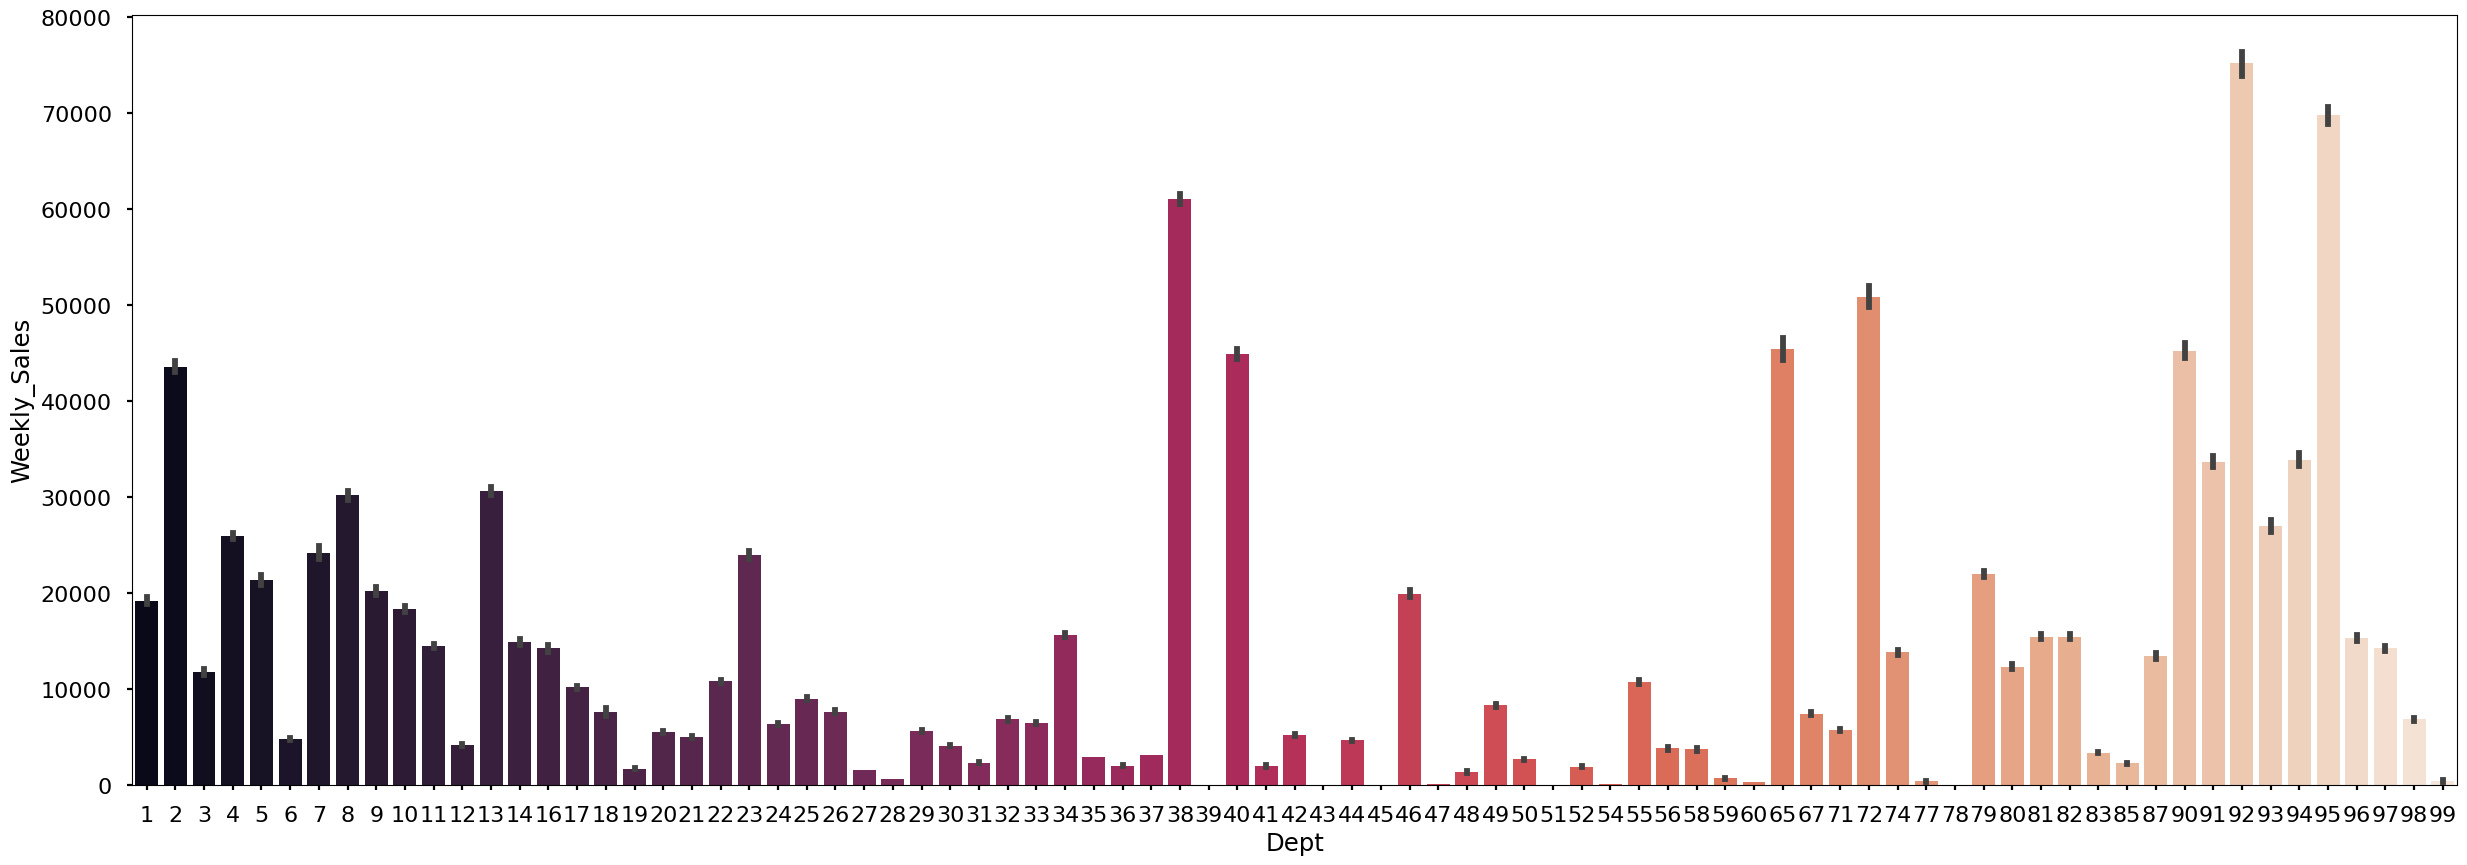

In [333]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df, palette='rocket')

The first graph indicates that one department, between 60 and 80 (likely department 72), shows higher sales values. However, when considering the averages, department 92 exhibits higher mean sales. Department 72 appears to be a seasonal department, showing spikes in sales during certain times, while department 92 consistently maintains higher average sales over time.

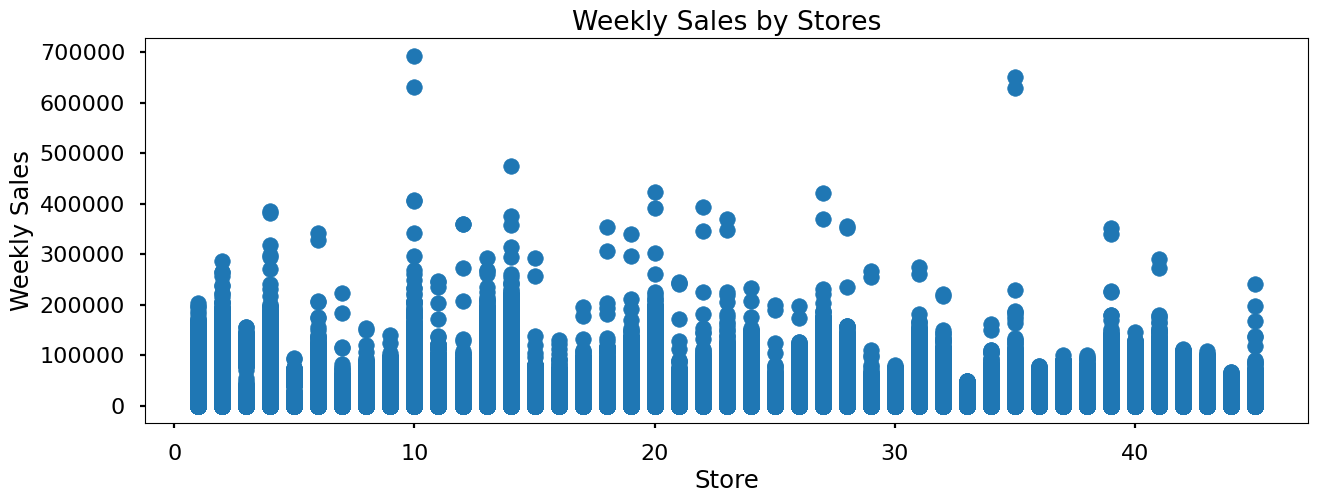

In [334]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Stores')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

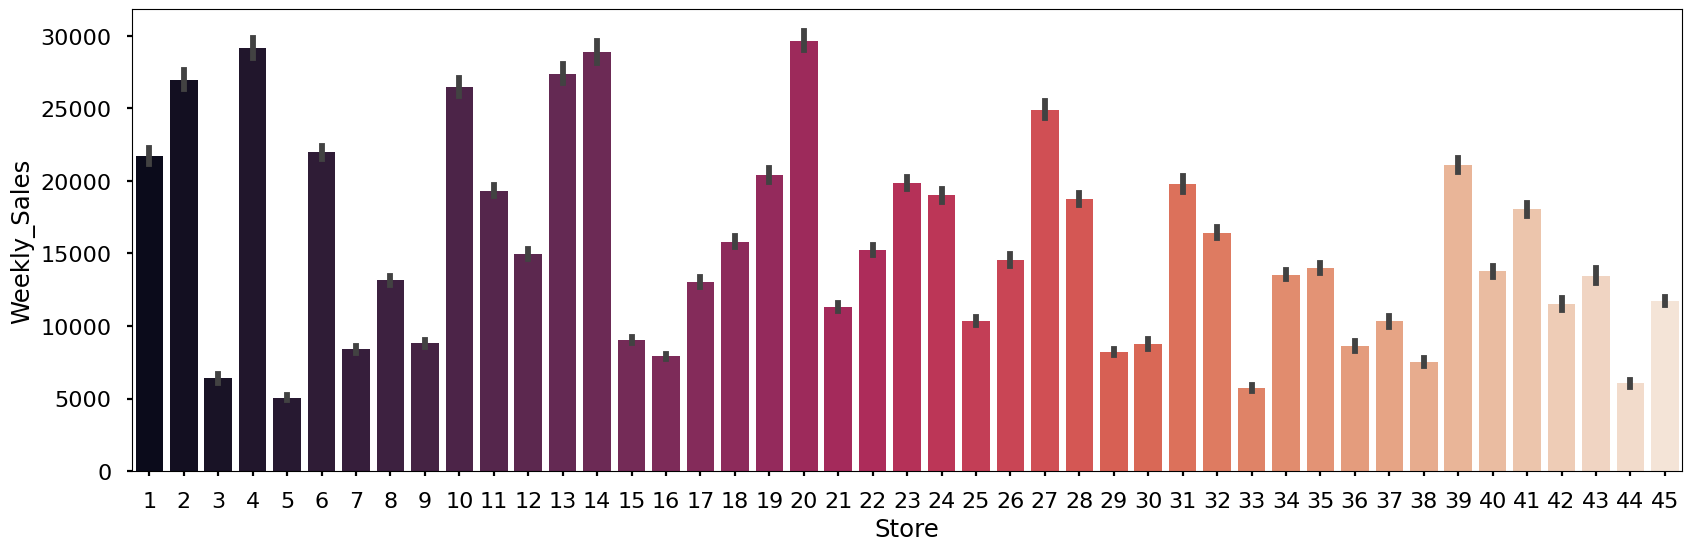

In [335]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df, palette='rocket')

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

## Changing Date to Datetime and Creating New Columns

In [336]:
df["Date"] = pd.to_datetime(df['Date'])
df['week'] = df['Date'].dt.isocalendar().week
df['month'] = df["Date"].dt.month
df['year'] = df['Date'].dt.year

In [337]:
df.groupby('month')['Weekly_Sales'].mean()

,Weekly_Sales
month,
1,14182.239153
2,16048.701191
3,15464.817698
4,15696.435193
5,15845.556200
6,16397.605478
7,15905.472425
8,16113.800069
9,15147.216063


In [338]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

,Weekly_Sales
year,
2010,16318.648285
2011,16007.797985
2012,15748.265005


<Axes: xlabel='month'>

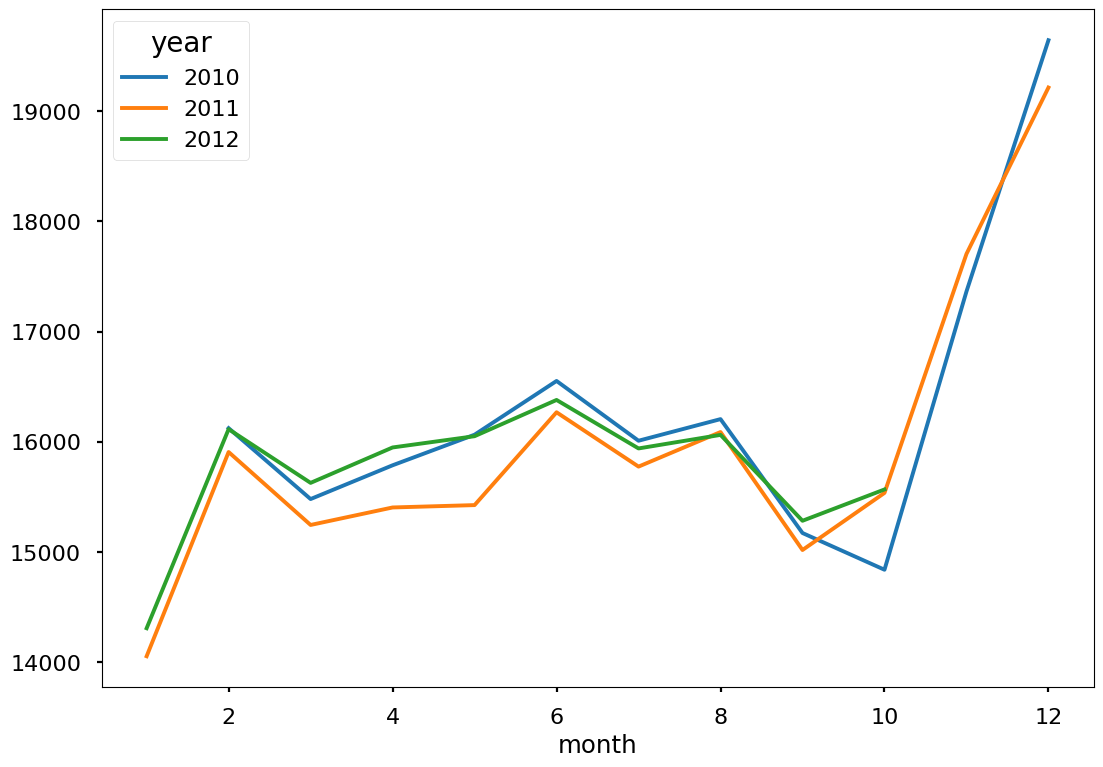

In [339]:
monthly_sales = pd.pivot_table(df, values='Weekly_Sales', columns='year', index='month')
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

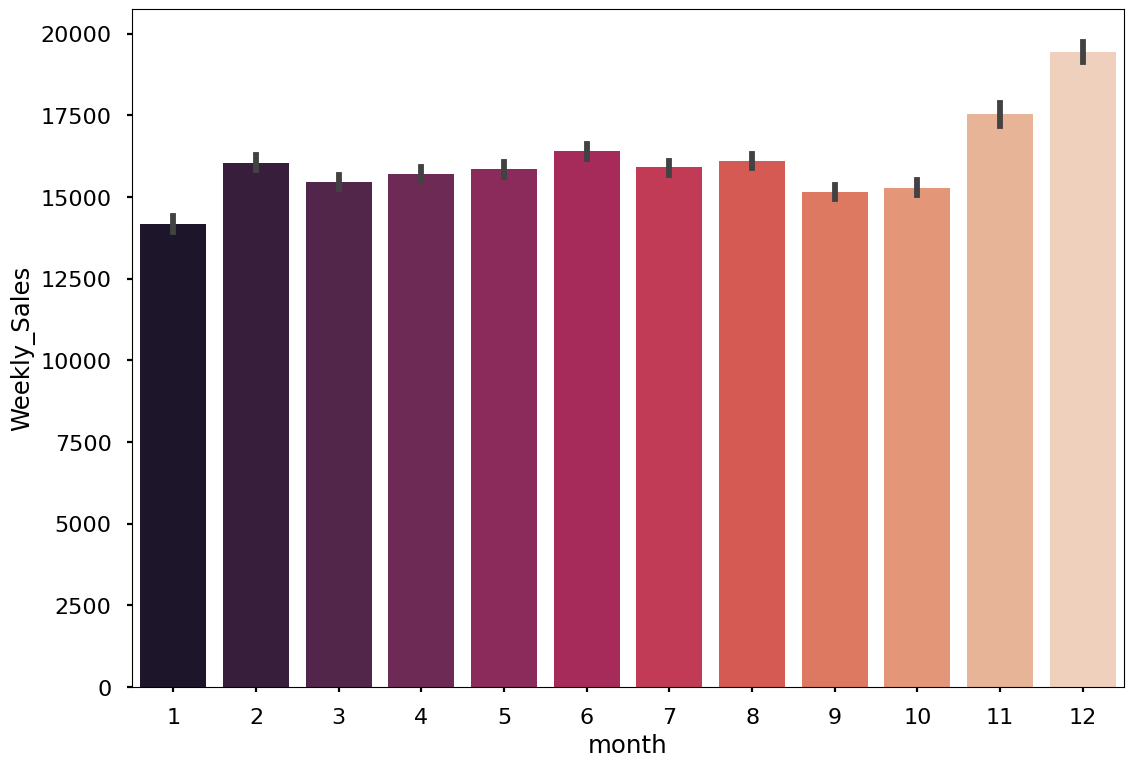

In [340]:
fig = sns.barplot(x = 'month', y = 'Weekly_Sales', data = df, palette="rocket")

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [341]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

,Weekly_Sales
week,
51,26454.164116
47,22269.601768
50,20478.421134
49,18731.794840
22,16856.650245


Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

<Axes: xlabel='week'>

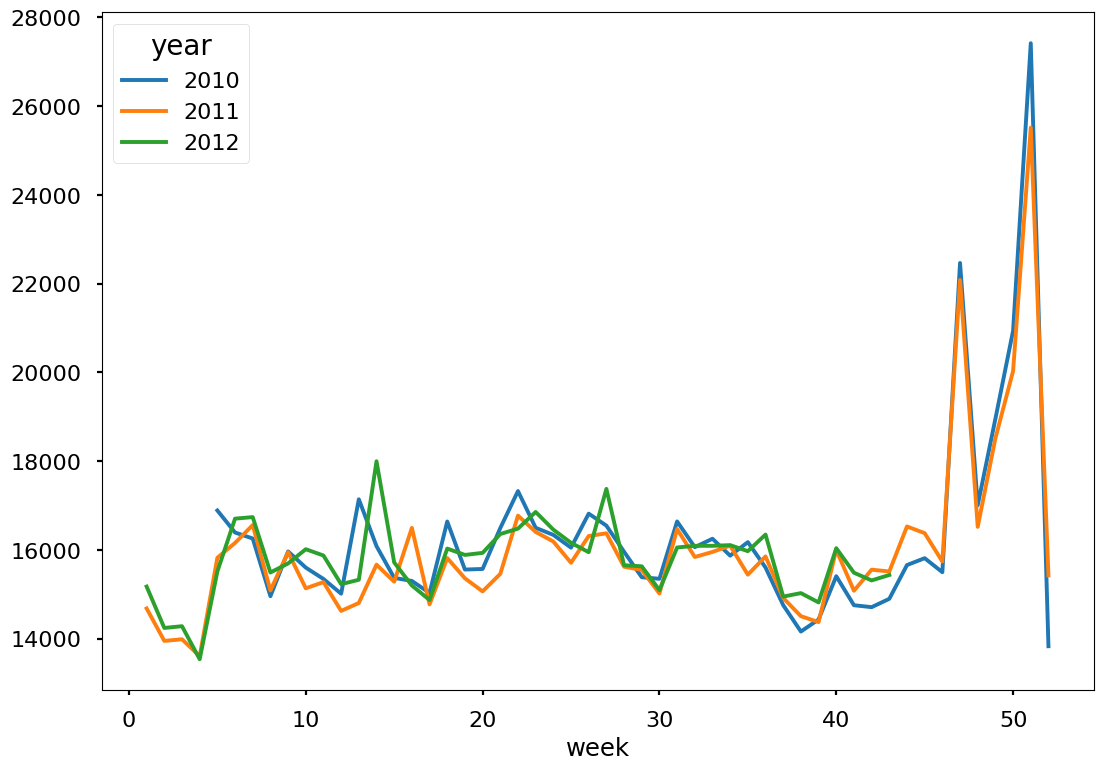

In [342]:
weekly_sales = pd.pivot_table(df, values='Weekly_Sales', columns='year', index='week')
weekly_sales.plot()

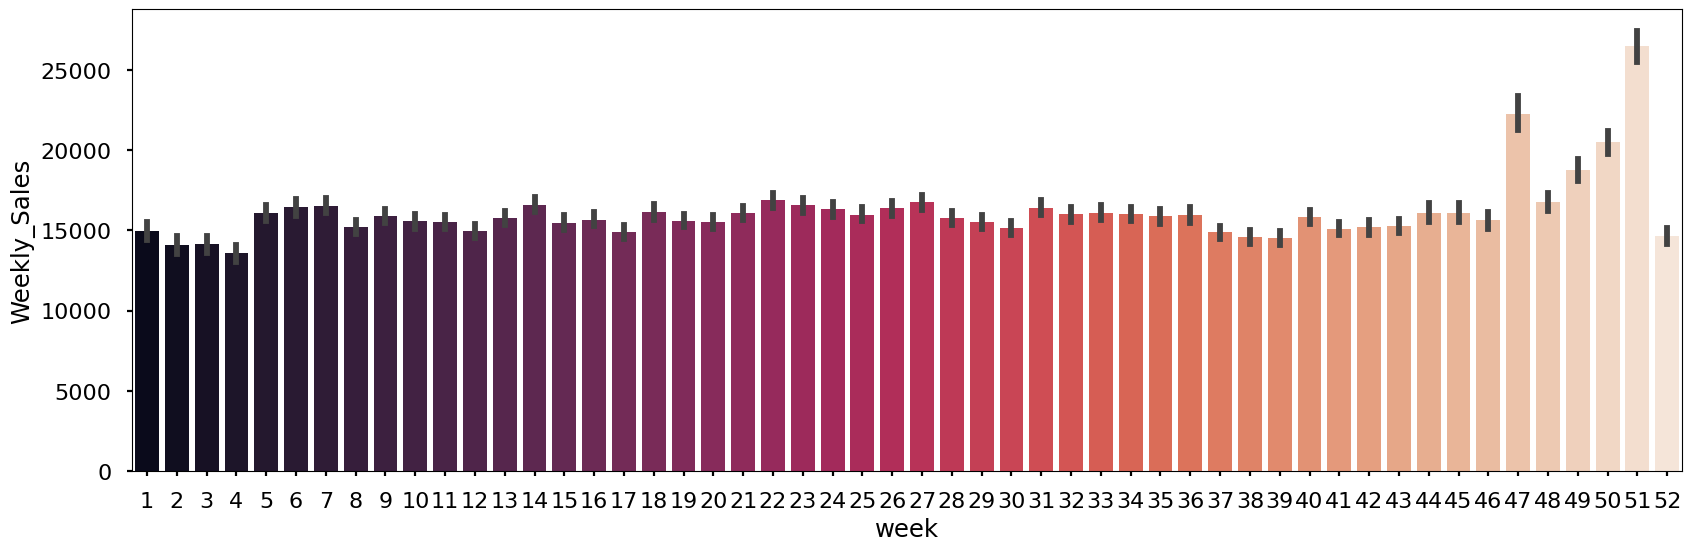

In [343]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x = 'week', y = 'Weekly_Sales', data = df, palette="rocket")

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

## Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

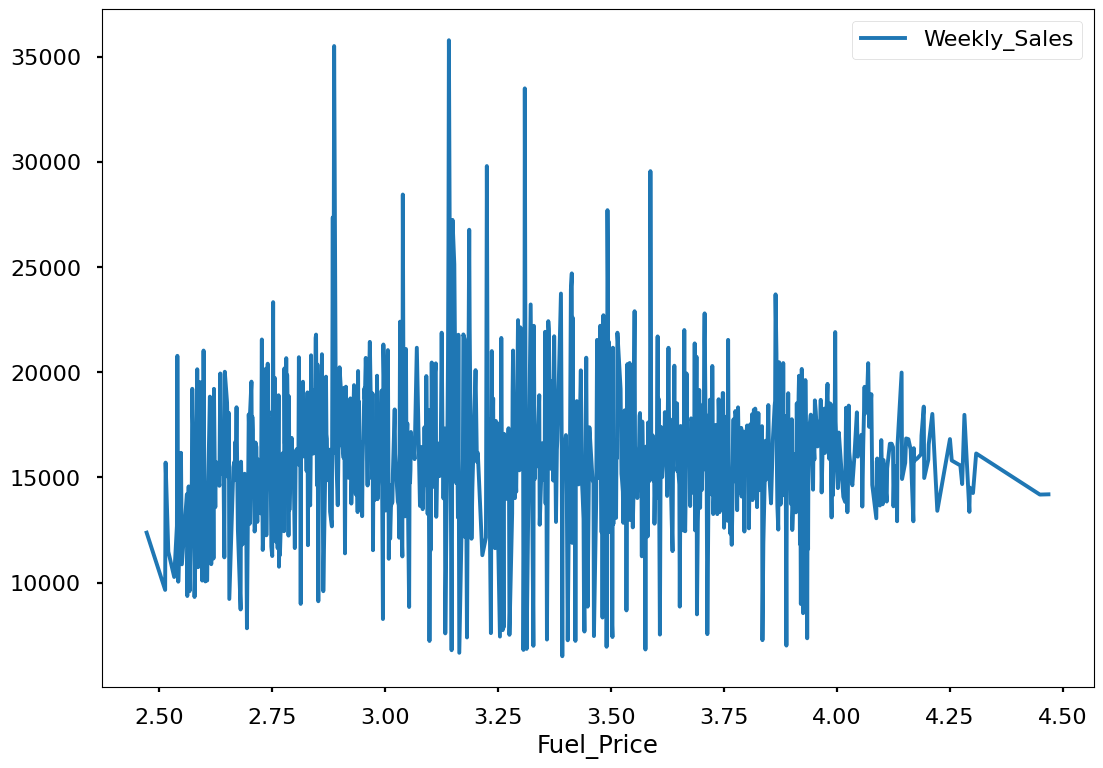

In [344]:
fuel_price = pd.pivot_table(df, values='Weekly_Sales', index = 'Fuel_Price')
fuel_price.plot()

<Axes: xlabel='Temperature'>

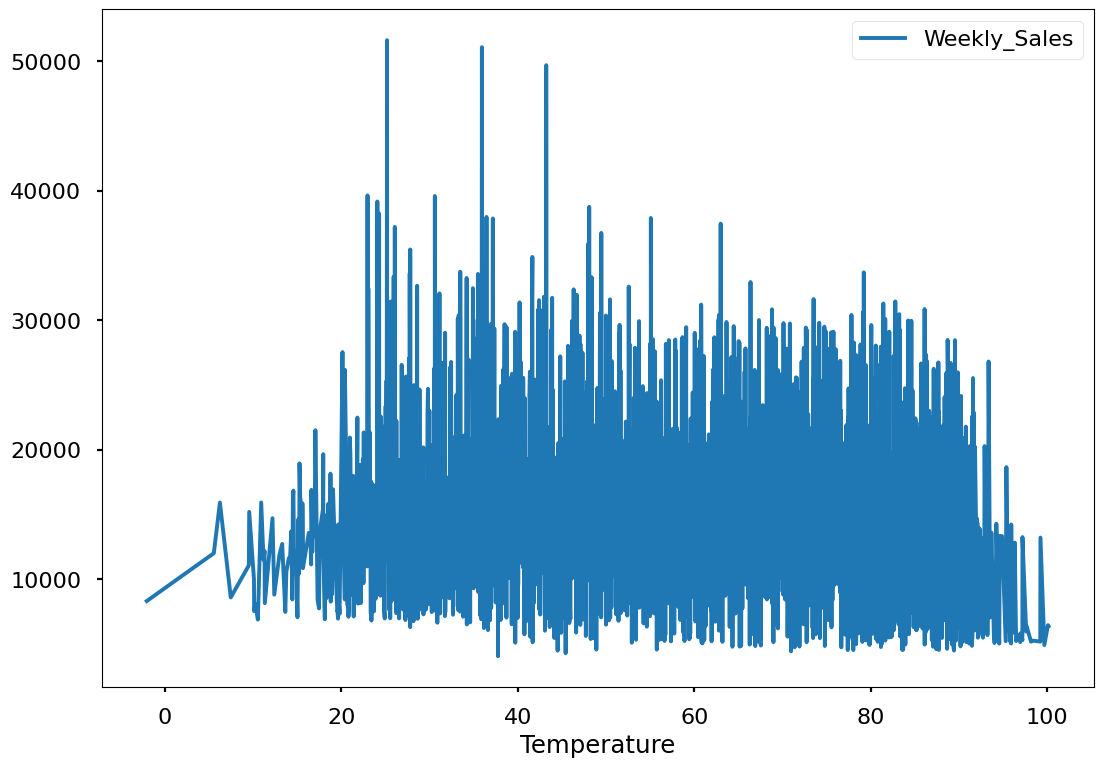

In [345]:
temp = pd.pivot_table(df, values='Weekly_Sales', index='Temperature')
temp.plot()

<Axes: xlabel='CPI'>

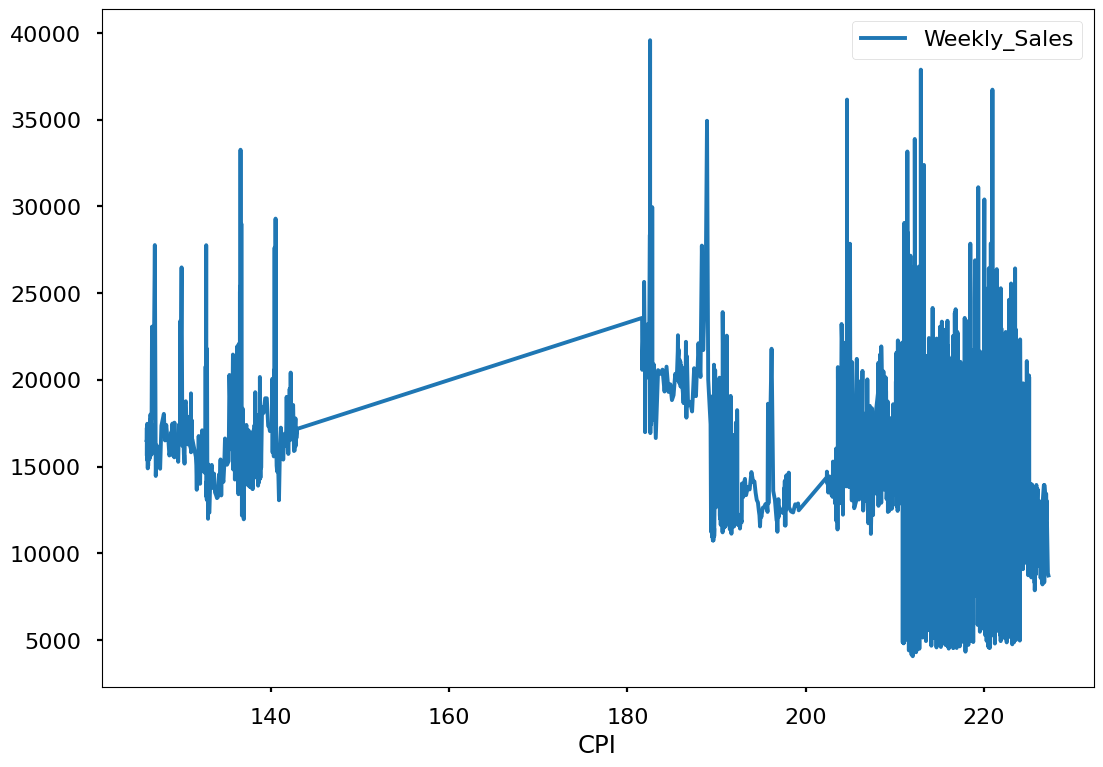

In [346]:
CPI = pd.pivot_table(df, values='Weekly_Sales', index='CPI')
CPI.plot()

<Axes: xlabel='Unemployment'>

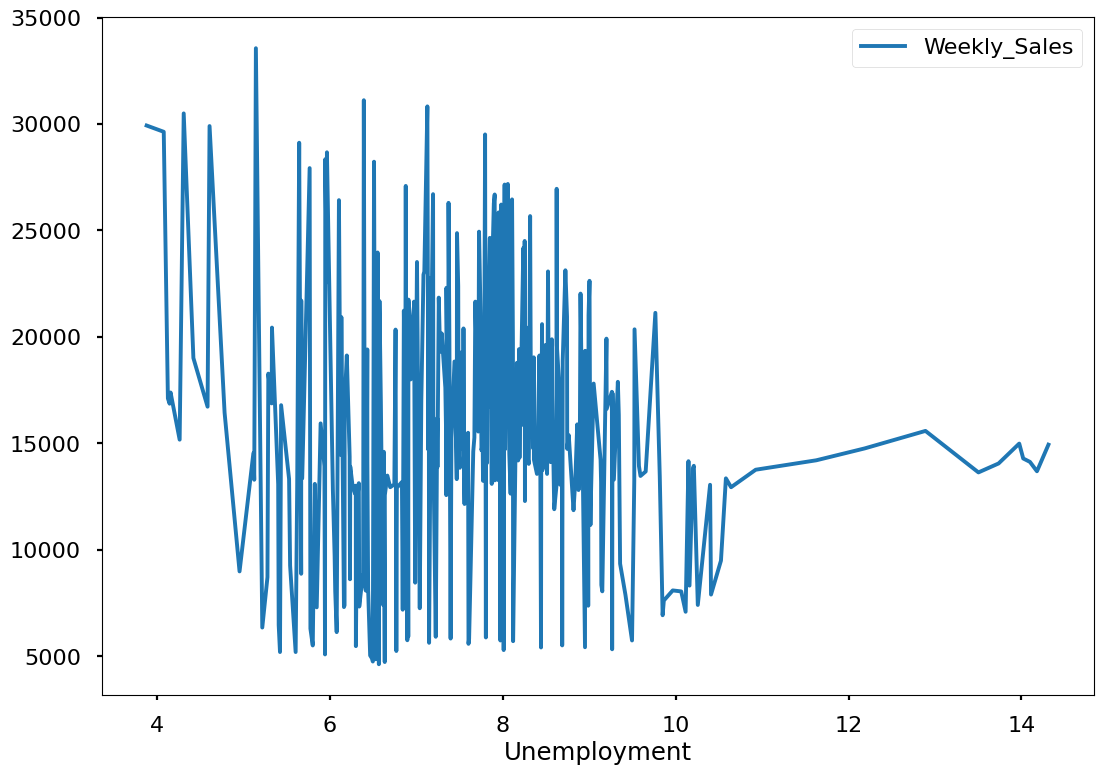

In [347]:
unemployment = pd.pivot_table(df, values='Weekly_Sales', index='Unemployment')
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

In [348]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

## Findings and Explorations

## Cleaning Process

1. The dataset contains minimal missing values, with all columns thoroughly checked.
2. Rows with weekly sales higher than zero were selected, and negative values (0.3% of the data) were dropped.
3. Null values in markdowns were replaced with zero, as they indicated no markdowns for that department.

## Explorations & Findings

1. There are 45 stores and 81 department in data. Departments are not same in all stores.
2. Although department 72 has higher weekly sales values, on average department 92 is the best. It shows us, some departments has higher values as seasonal like Thanksgiving. It is consistant when we look at the top 5 sales in data, all of them belongs to 72th department at Thanksgiving holiday time.
3. Although stores 10 and 35 have higher weekly sales values sometimes, in general average store 20 and store 4 are on the first and second rank. It means that some areas has higher seasonal sales.
4. Stores has 3 types as A, B and C according to their sizes. Almost half of the stores are bigger than 150000 and categorized as A. According to type, sales of the stores are changing.
5. As expected, holiday average sales are higher than normal dates.
6. Christmas holiday introduces as the last days of the year. But people generally shop at 51th week. So, when we look at the total sales of holidays, Thankgiving has higher sales between them which was assigned by Walmart.
7. Year 2010 has higher sales than 2011 and 2012. But, November and December sales are not in the data for 2012. Even without highest sale months, 2012 is not significantly less than 2010, so after adding last two months, it can be first.
8. It is obviously seen that week 51 and 47 have higher values and 50-48 weeks follow them. Interestingly, 5th top sales belongs to 22th week of the year. This results show that Christmas, Thankgiving and Black Friday are very important than other weeks for sales and 5th important time is 22th week of the year and it is end of the May, when schools are closed. Most probably, people are preparing for holiday at the end of the May.
9. January sales are significantly less than other months. This is the result of November and December high sales. After two high sales month, people prefer to pay less on January.
10. CPI, temperature, unemployment rate and fuel price have no pattern on weekly sales.

## First Trial with Random Forest

In [349]:
pd.options.display.max_columns=100

In [350]:
df = pd.read_csv('./clean_data.csv')

In [351]:
df.drop(columns=['Unnamed: 0'], inplace = True)

In [352]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

## Encoding the Data

changing holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3.

In [353]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [354]:
type_group = {'A':1, 'B':2, 'C':3} # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [355]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [356]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [357]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int)

In [358]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int)

In [359]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int)

In [360]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

## Observation of Interactions between Features

Dropped the divided holiday columns from the dataset and proceed without them. To preserve the encoded data, assign the current DataFrame to a new one for use in this experiment.

In [361]:
drop_col = ['Super_Bowl', 'Thanksgiving', 'Labor_Day', 'Christmas']
df_new.drop(drop_col, axis=1, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

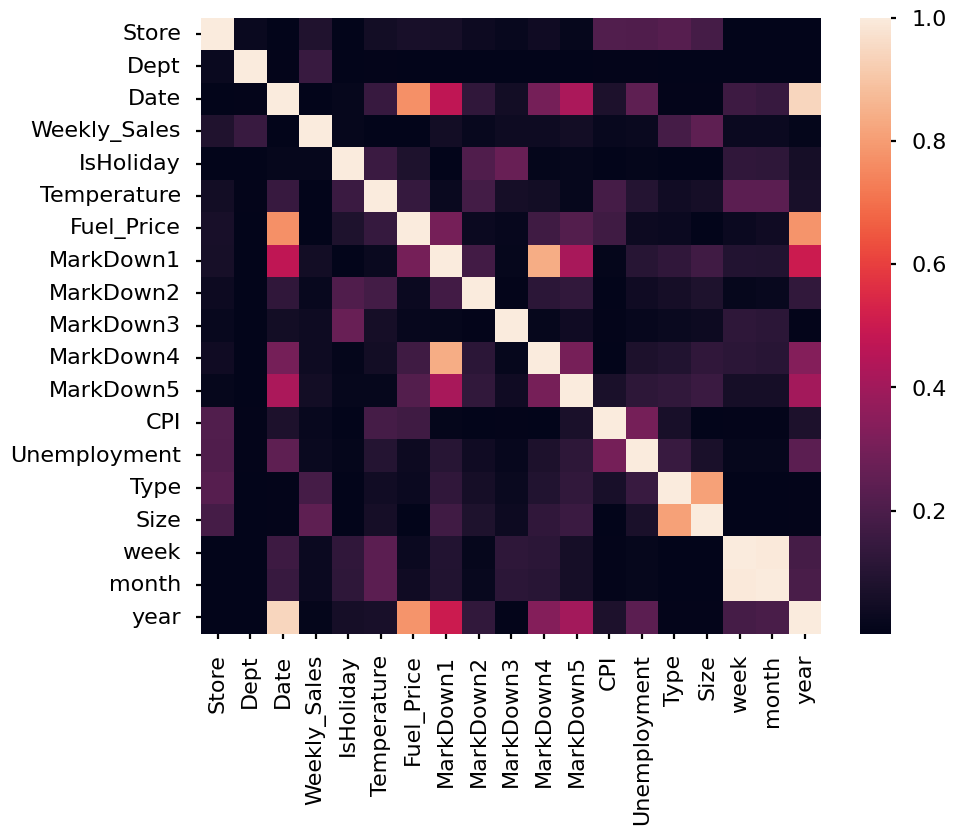

In [362]:
plt.figure(figsize = (10,8))
sns.heatmap(df_new.corr().abs())
plt.show

Temperature, unemployment, and CPI show no significant effect on weekly sales, so they will be dropped. Additionally, Markdown 4 and 5 are highly correlated with Markdown 1, which could potentially lead to multicollinearity issues. Therefore, these columns will also be removed. The model will be tested without them to evaluate performance.

In [363]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

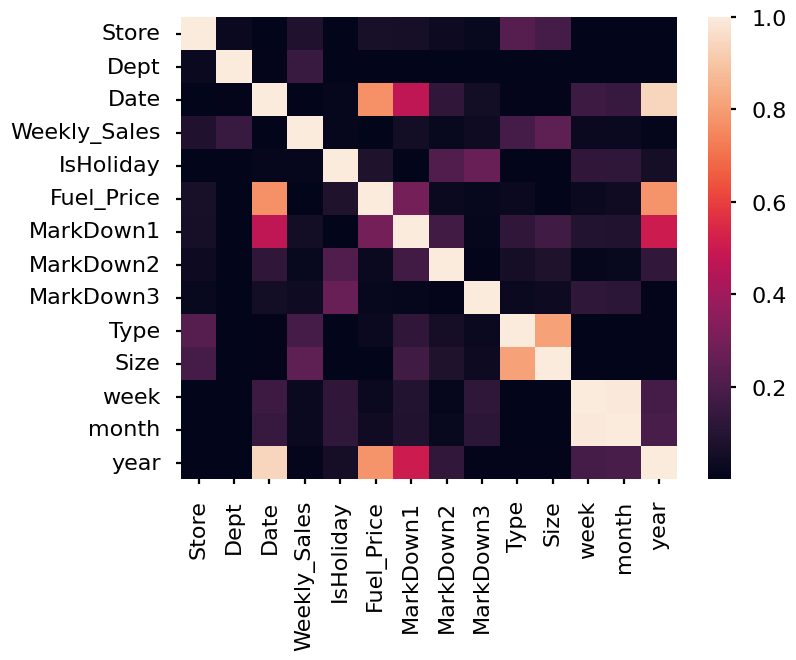

In [364]:
plt.figure(figsize = (8,6))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales

In [365]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

## Creating Train-Test Splits

In [366]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [367]:
X = df_new[used_cols] # to keep train and test X values together

The data contains sufficient information, such as the week of the year, making it unnecessary to retain the date columns, which were subsequently dropped.

In [368]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

## Metric Definition Function

In [369]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

## Random Forest Regressor

In [370]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()



#making pipe tp use scaler and regressor together
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train, y_train)

# predictions on train set
y_pred = pipe.predict(X_train)

# predictions on test set
y_pred_test = pipe.predict(X_test)

In [371]:
wmae_test(y_test, y_pred_test)

5697.712824122053

# To See Feature Importance

In [372]:
X = X.drop(['Date'], axis = 1) #dropping date column from X

Feature ranking:
1. feature 1 (0.734834)
2. feature 8 (0.103608)
3. feature 0 (0.058842)
4. feature 7 (0.039401)
5. feature 9 (0.021299)
6. feature 3 (0.018655)
7. feature 10 (0.008636)
8. feature 6 (0.005390)
9. feature 4 (0.003045)
10. feature 5 (0.002715)
11. feature 2 (0.002032)
12. feature 11 (0.001543)


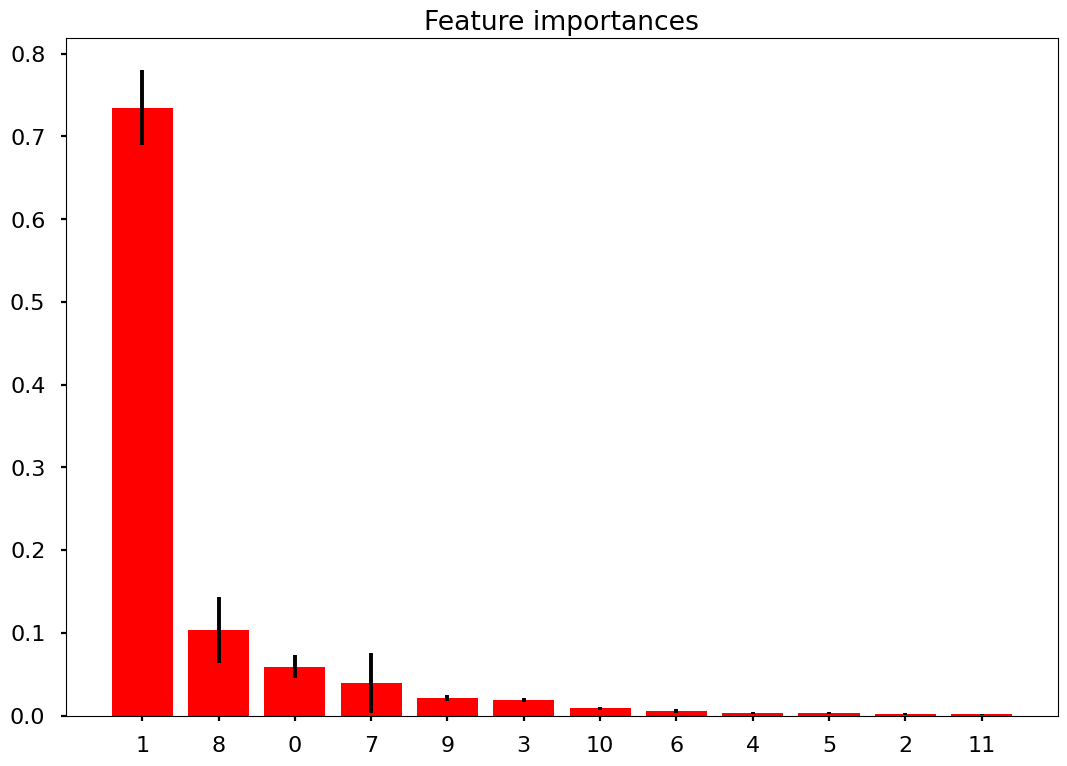

In [373]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [374]:
X1_train = X_train.drop(['month'], axis=1) # dropping month
X1_test = X_test.drop(['month'], axis=1)

## Model Again without Month

In [375]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X1_train, y_train)

# predictions on train set
y_pred = pipe.predict(X1_train)

# predictions on test set
y_pred_test = pipe.predict(X1_test)

In [376]:
wmae_test(y_test, y_pred_test)

5450.408821519322

## Model with Whole Data

In [377]:
# splitting train-test to whole dataset
train_data_enc = df_encoded[:int(0.7*(len(df_encoded)))]
test_data_enc = df_encoded[int(0.7*(len(df_encoded))):]

target = "Weekly_Sales"
used_cols1 = [c for c in df_encoded.columns.to_list() if c not in [target]] # all columns except price

X_train_enc = train_data_enc[used_cols1]
X_test_enc = test_data_enc[used_cols1]
y_train_enc = train_data_enc[target]
y_test_enc = test_data_enc[target]

In [378]:
X_enc = df_encoded[used_cols1] # to get together train,test splits

In [379]:
X_enc = X_enc.drop(['Date'], axis=1) #dropping date column for whole X

In [380]:
X_train_enc = X_train_enc.drop(['Date'], axis=1) # dropping date from train and test
X_test_enc= X_test_enc.drop(['Date'], axis=1)

In [381]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=35,
                           max_features = 'sqrt',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc, y_train_enc)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc)

In [382]:
wmae_test(y_test_enc, y_pred_test_enc)

2684.1200397952525

We found better results for whole data, it means our model can learn from columns which I dropped before.

## Feature Importance for Whole Encoded Dataset

Feature ranking:
1. feature 1 (0.743021)
2. feature 13 (0.073903)
3. feature 12 (0.040787)
4. feature 0 (0.033258)
5. feature 10 (0.030062)
6. feature 11 (0.017276)
7. feature 18 (0.011946)
8. feature 3 (0.011041)
9. feature 4 (0.010113)
10. feature 19 (0.005986)
11. feature 7 (0.004673)
12. feature 9 (0.003993)
13. feature 8 (0.003554)
14. feature 5 (0.003447)
15. feature 6 (0.002533)
16. feature 20 (0.001175)
17. feature 16 (0.001059)
18. feature 2 (0.000916)
19. feature 17 (0.000683)
20. feature 15 (0.000301)
21. feature 14 (0.000272)


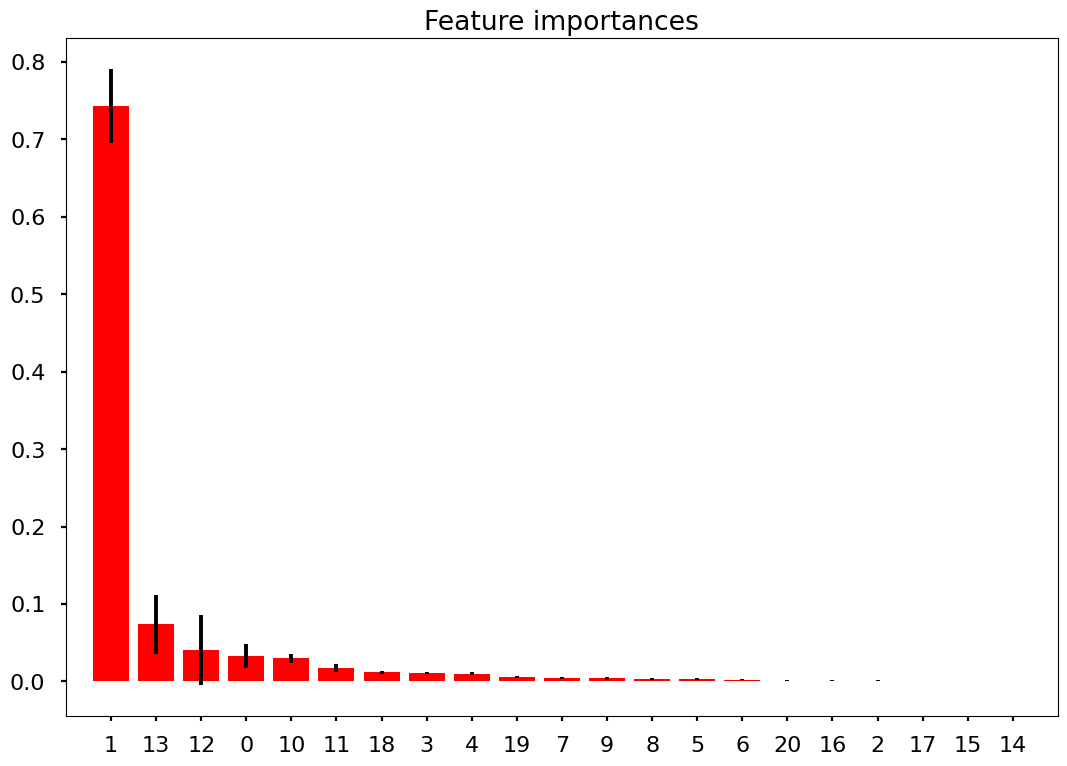

In [383]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Printing the feature ranking
print("Feature ranking:")

for f in range(X_enc.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plotting the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_enc.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_enc.shape[1]), indices)
plt.xlim([-1, X_enc.shape[1]])
plt.show()

In [384]:
df_encoded_new = df_encoded.copy() # taking copy of encoded data to keep it without change.
df_encoded_new.drop(drop_col, axis=1, inplace=True)

## Model According to Feature Importance

In [385]:
#train-test splitting
train_data_enc_new = df_encoded_new[:int(0.7*(len(df_encoded_new)))]
test_data_enc_new = df_encoded_new[int(0.7*(len(df_encoded_new))):]

target = "Weekly_Sales"
used_cols2 = [c for c in df_encoded_new.columns.to_list() if c not in [target]] # all columns except price

X_train_enc1 = train_data_enc_new[used_cols2]
X_test_enc1 = test_data_enc_new[used_cols2]
y_train_enc1 = train_data_enc_new[target]
y_test_enc1 = test_data_enc_new[target]

#droping date from train-test
X_train_enc1 = X_train_enc1.drop(['Date'], axis=1)
X_test_enc1= X_test_enc1.drop(['Date'], axis=1)

In [386]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=40,
                           max_features = 'log2',min_samples_split = 10)

scaler=RobustScaler()
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc1, y_train_enc1)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc1)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc1)

In [387]:
pipe.score(X_test_enc1,y_test_enc1)

0.735025800467954

In [388]:
wmae_test(y_test_enc1, y_pred_test_enc)

2018.8987478432969

## Model with Dropping Month Column

In [389]:
df_encoded_new1 = df_encoded.copy()
df_encoded_new1.drop(drop_col, axis=1, inplace=True)

In [390]:
df_encoded_new1 = df_encoded_new1.drop(['Date'], axis=1)

In [391]:
df_encoded_new1 = df_encoded_new1.drop(['month'], axis=1)

In [392]:
#train-test split
train_data_enc_new1 = df_encoded_new1[:int(0.7*(len(df_encoded_new1)))]
test_data_enc_new1 = df_encoded_new1[int(0.7*(len(df_encoded_new1))):]

target = "Weekly_Sales"
used_cols3 = [c for c in df_encoded_new1.columns.to_list() if c not in [target]] # all columns except price

X_train_enc2 = train_data_enc_new1[used_cols3]
X_test_enc2 = test_data_enc_new1[used_cols3]
y_train_enc2 = train_data_enc_new1[target]
y_test_enc2 = test_data_enc_new1[target]

In [393]:
#modeling part
pipe = make_pipeline(scaler,rf)

pipe.fit(X_train_enc2, y_train_enc2)

# predictions on train set
y_pred_enc = pipe.predict(X_train_enc2)

# predictions on test set
y_pred_test_enc = pipe.predict(X_test_enc2)

In [394]:
pipe.score(X_test_enc2,y_test_enc2)

0.7104703970074872

In [395]:
wmae_test(y_test_enc2, y_pred_test_enc)

2191.3785727644176

In [396]:
df_results = pd.DataFrame(columns=["Model", "Info",'WMAE']) # result df for showing results together

In [397]:
import pandas as pd

# writing results to df
# Create the new row as a DataFrame
new_row = pd.DataFrame([{
    "Model": 'RandomForestRegressor' ,
    "Info": 'w/out divided holiday columns' ,
    'WMAE' : 5697}])

# Assuming df_results is already created with columns ["Model", "Info",'WMAE']
df_results = pd.concat([df_results, new_row], ignore_index=True)

# Similarly, for other rows:
df_results = pd.concat([df_results, pd.DataFrame([{"Model": 'RandomForestRegressor', "Info": 'w/out month column', 'WMAE': 5450}])], ignore_index=True)
df_results = pd.concat([df_results, pd.DataFrame([{"Model": 'RandomForestRegressor', "Info": 'whole data', 'WMAE': 2018}])], ignore_index=True)
df_results = pd.concat([df_results, pd.DataFrame([{"Model": 'RandomForestRegressor', "Info": 'whole data with feature selection', 'WMAE': 2018}])], ignore_index=True)
df_results = pd.concat([df_results, pd.DataFrame([{"Model": 'RandomForestRegressor', "Info": 'whole data with feature selection w/out month', 'WMAE': 2191}])], ignore_index=True)

In [398]:
df_results

,Model,Info,WMAE
0,RandomForestRegressor,w/out divided holiday columns,5697
1,RandomForestRegressor,w/out month column,5450
2,RandomForestRegressor,whole data,2018
3,RandomForestRegressor,whole data with feature selection,2018
4,RandomForestRegressor,whole data with feature selection w/out month,2191


## Time Series Models

In [399]:
df.head() # to see my data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,True,False,False,False,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,False,False,False,False,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,False,False,False,False,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,False,False,False,False,9,3,2010


In [400]:
df["Date"] = pd.to_datetime(df["Date"]) #changing data to datetime for decomposing

In [401]:
df.set_index('Date', inplace=True) #seting date as index

## Plotting Sales

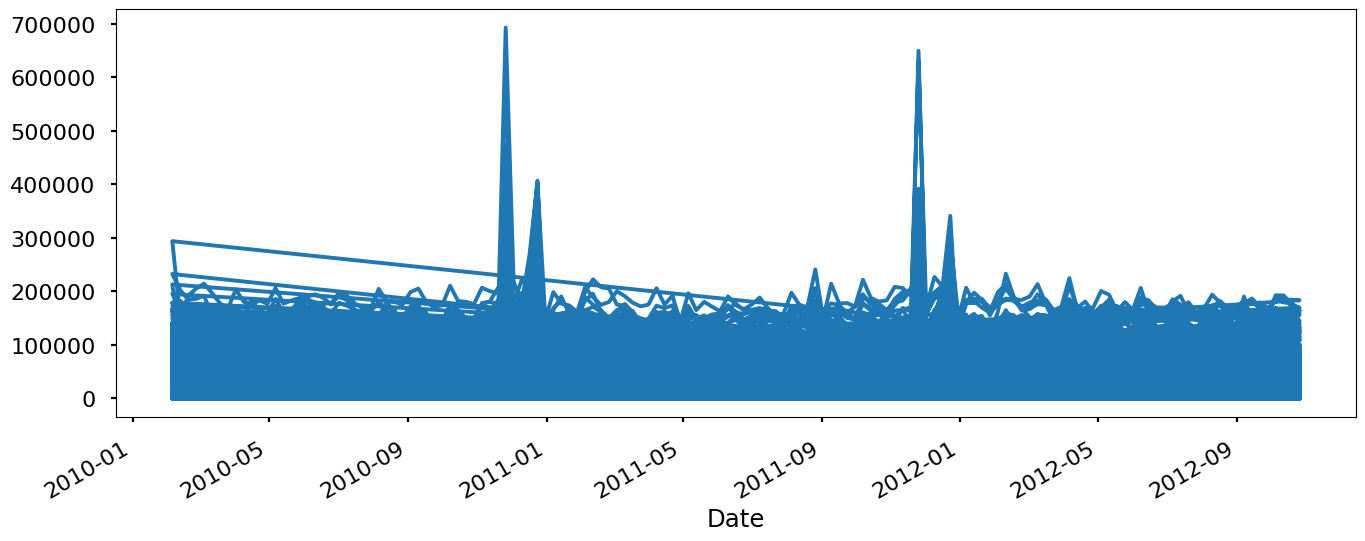

In [402]:
plt.figure(figsize=(16,6))
df['Weekly_Sales'].plot()
plt.show()


The data contains numerous duplicate values, which will be aggregated on a weekly basis.

In [403]:
df_week = df.resample('W').agg({'Weekly_Sales': 'mean'}) #resample data as weekly, specify 'mean' for 'Weekly_Sales'

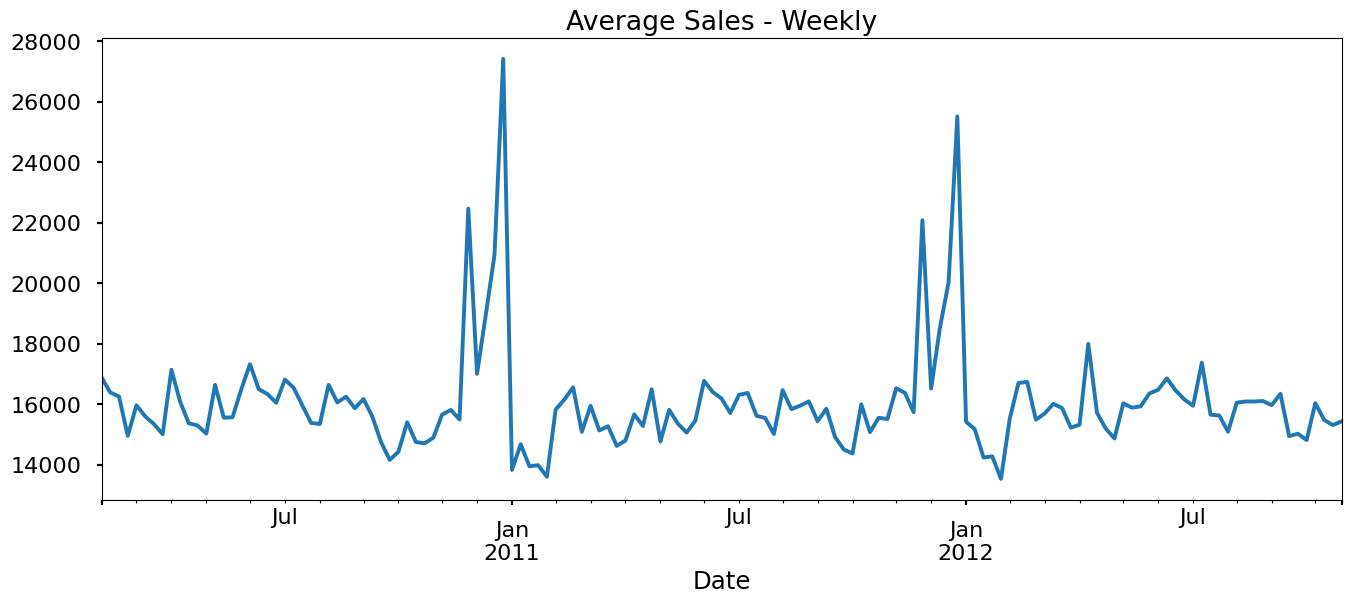

In [404]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

To observe average sales trends clearly, the data will first be collected on a weekly basis. Additionally, resampling the data to a monthly frequency will reveal broader patterns and seasonality.

In [405]:
df_month = df.resample('MS').mean(numeric_only=True) # resampling as monthly, only calculate mean for numeric columns

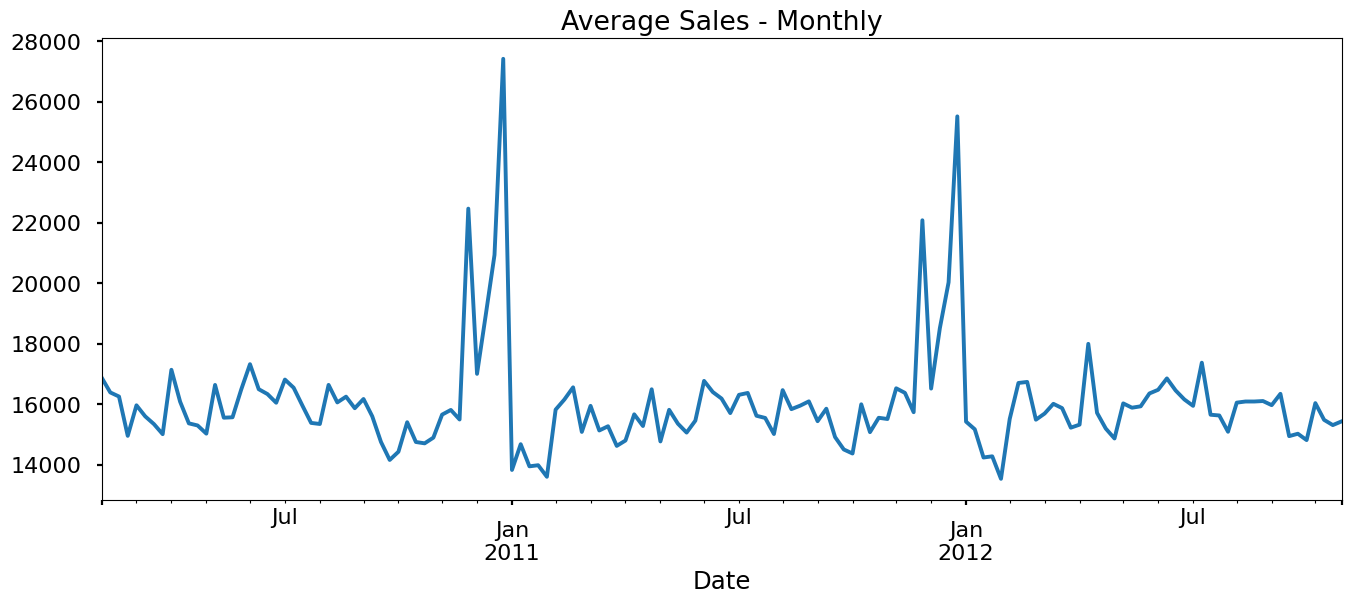

In [406]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

After converting the data to a monthly frequency, some patterns present in the weekly data became less visible. To retain these finer details, the analysis will proceed using the weekly resampled data. This approach preserves the granularity necessary to capture important patterns in the dataset.

## To Observe 2-weeks Rolling Mean and Std

My data is non-stationary. So, I will try to find more stationary version on it

In [407]:
# finding 2-weeks rolling mean and std
roll_mean = df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
roll_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

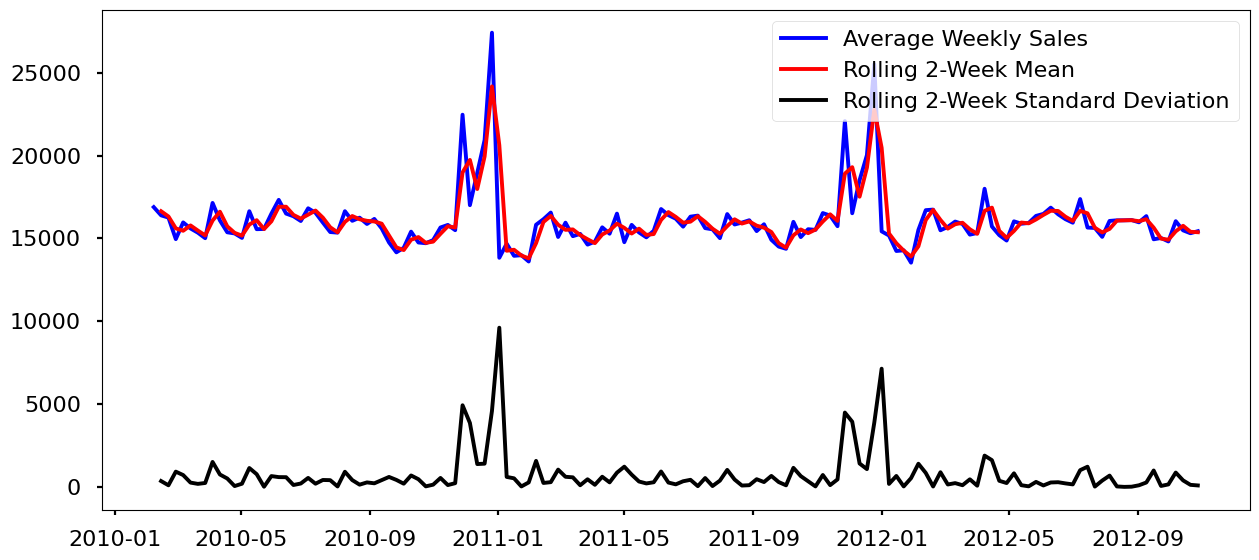

In [408]:
fig,ax = plt.subplots(figsize=(13,6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(roll_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

## Adfuller Test to Make Sure

In [409]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 2261.596421168073)

From test and my observations my data is not stationary. So, I will try to find more stationary version of it.

## Train - Test Split of Weekly Data

To take train-test splits continuosly, I split them manually, not random.

In [410]:
train_data = df_week[:int(0.7*(len(df_week)))]
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 1)
Test: (43, 1)


In [411]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]] # all columns except price

# assigning train-test X-y values

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

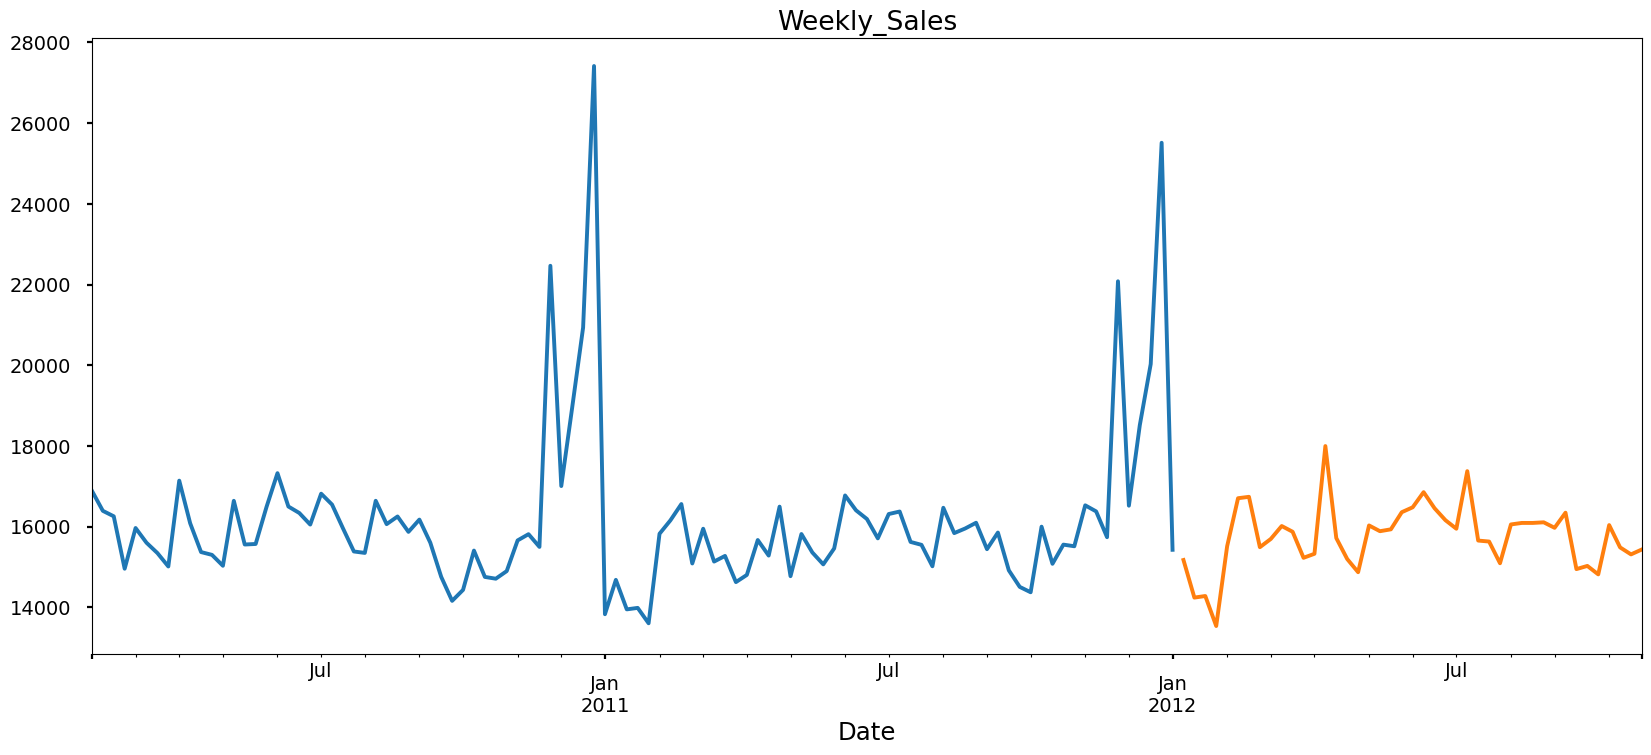

In [412]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

Blue line represents my train data, yellow is test data.

## Decomposing Weekly Data to Observe Seasonality

In [413]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20) #decomposing of weekly data

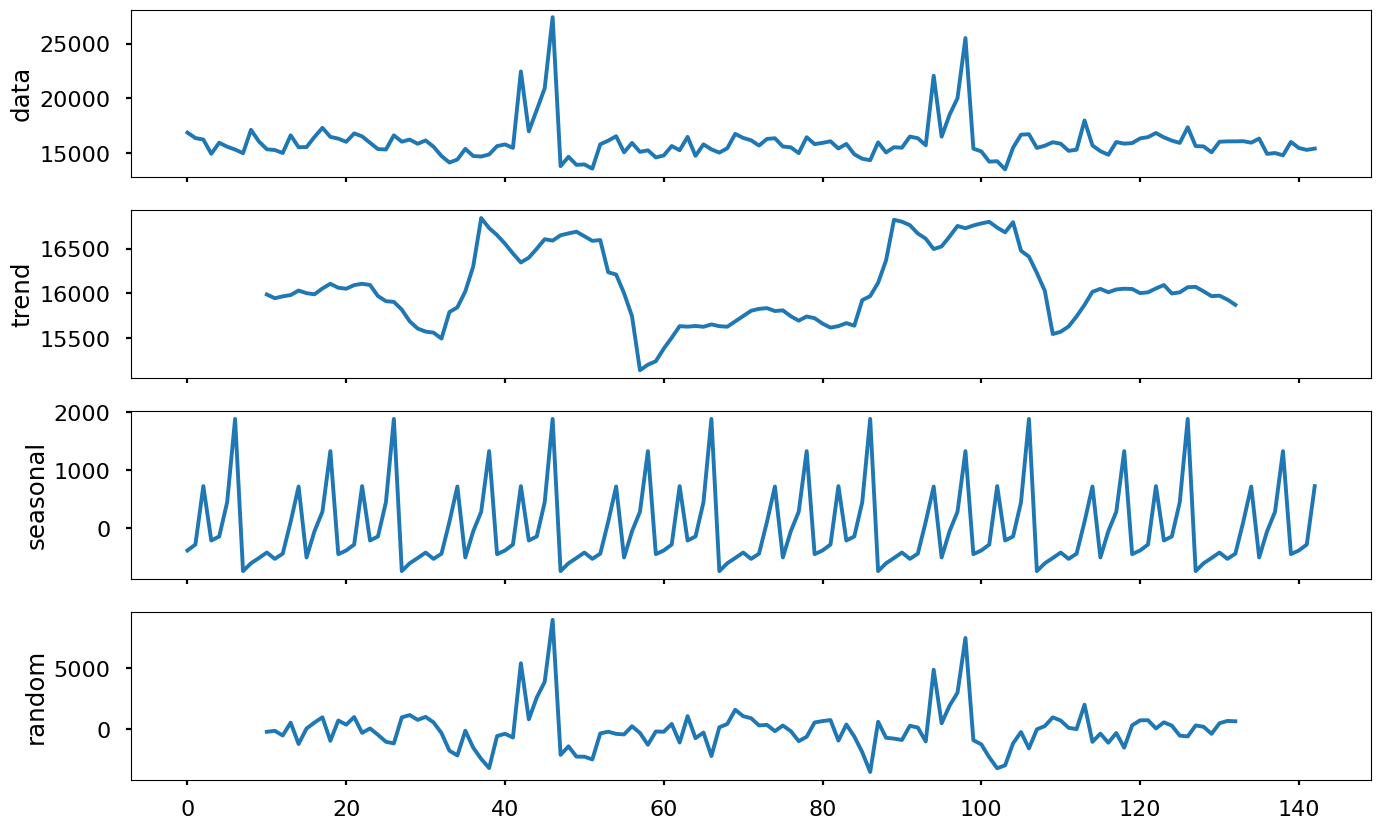

In [414]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the graphs above, every 20 step seasonality converges to beginning point. This helps me to tune my model.

## Trying To Make Data More Stationary

### 1. Difference

In [415]:
df_week_diff = df_week['Weekly_Sales'].diff().dropna() #creating difference values

In [416]:
# taking mean and std of differenced data
diff_roll_mean = df_week_diff.rolling(window=2, center=False).mean()
diff_roll_std = df_week_diff.rolling(window=2, center=False).std()

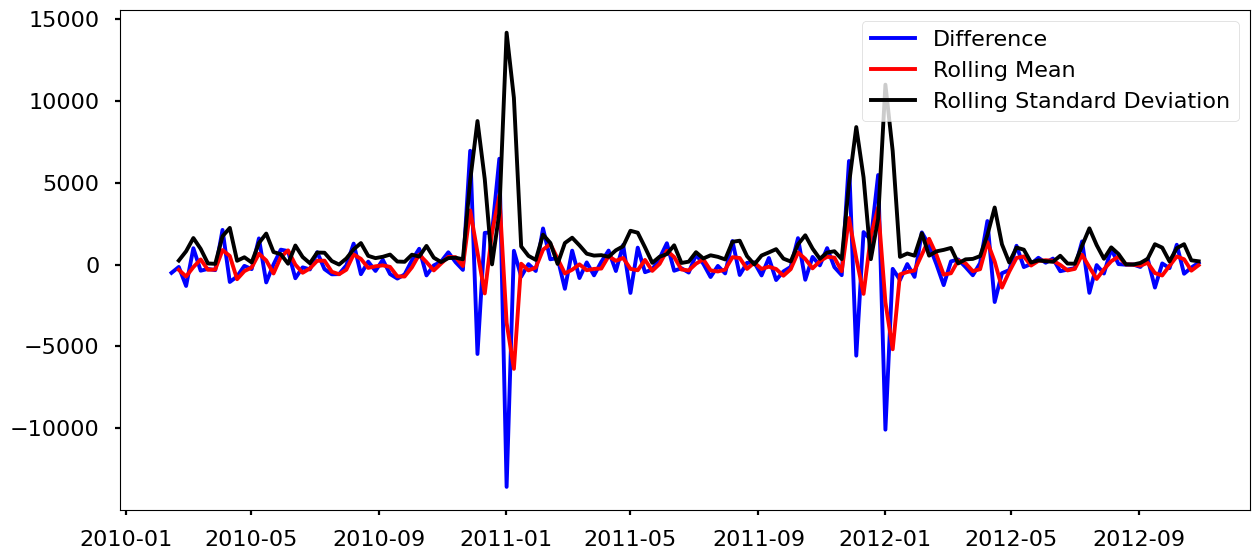

In [417]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_diff, color='blue',label='Difference')
ax.plot(diff_roll_mean, color='red', label='Rolling Mean')
ax.plot(diff_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

### 2.Shift

In [418]:
df_week_lag = df_week['Weekly_Sales'].shift().dropna() #shifting the data

In [419]:
lag_roll_mean = df_week_lag.rolling(window=2, center=False).mean()
lag_roll_std = df_week_lag.rolling(window=2, center=False).std()

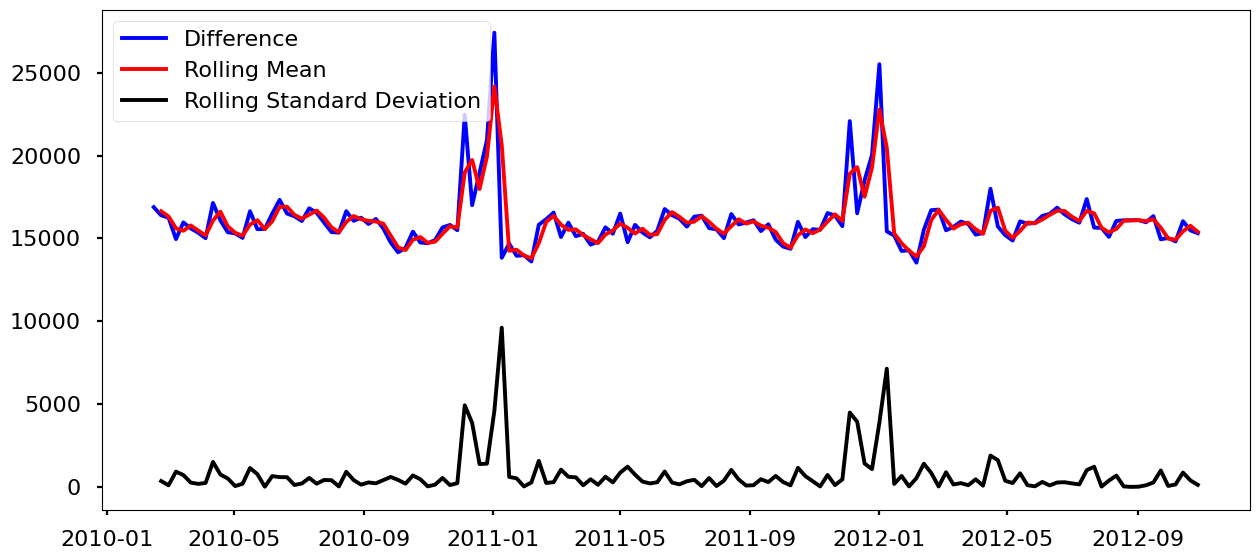

In [420]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week_lag, color='blue',label='Difference')
ax.plot(lag_roll_mean, color='red', label='Rolling Mean')
ax.plot(lag_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

### 3.Log

In [421]:
logged_week = np.log1p(df_week['Weekly_Sales']).dropna() #taking log of data

In [422]:
log_roll_mean = logged_week.rolling(window=2, center=False).mean()
log_roll_std = logged_week.rolling(window=2, center=False).std()

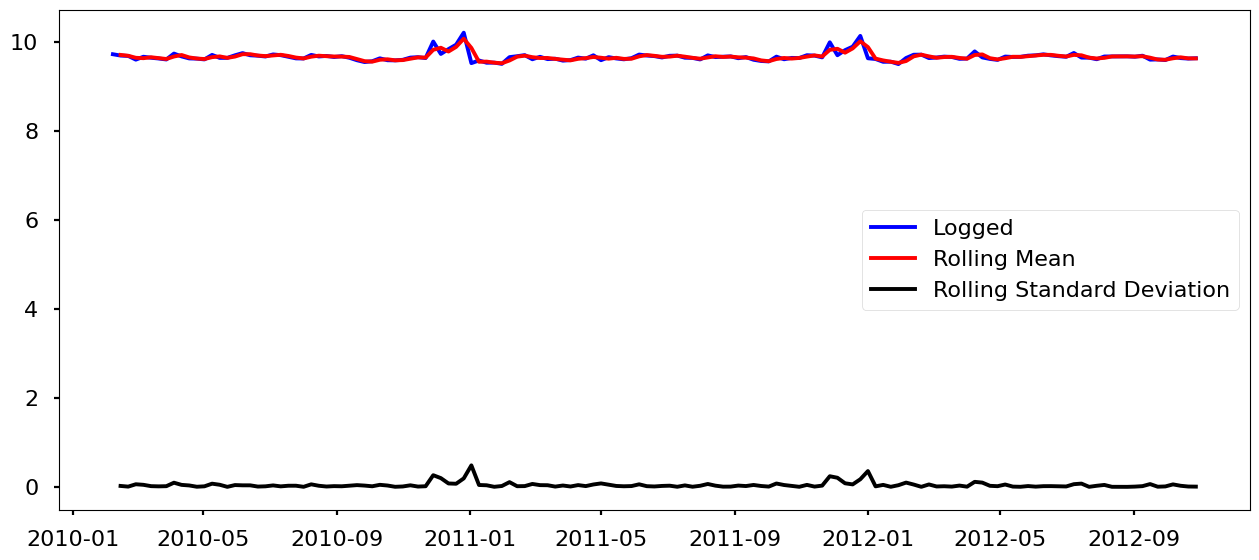

In [423]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(logged_week, color='blue',label='Logged')
ax.plot(log_roll_mean, color='red', label='Rolling Mean')
ax.plot(log_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

## Auto-ARIMA MODEL

## Train-Test Split

In [424]:
train_data_diff = df_week_diff [:int(0.7*(len(df_week_diff )))]
test_data_diff = df_week_diff [int(0.7*(len(df_week_diff ))):]

In [425]:
model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data_diff)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.28 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

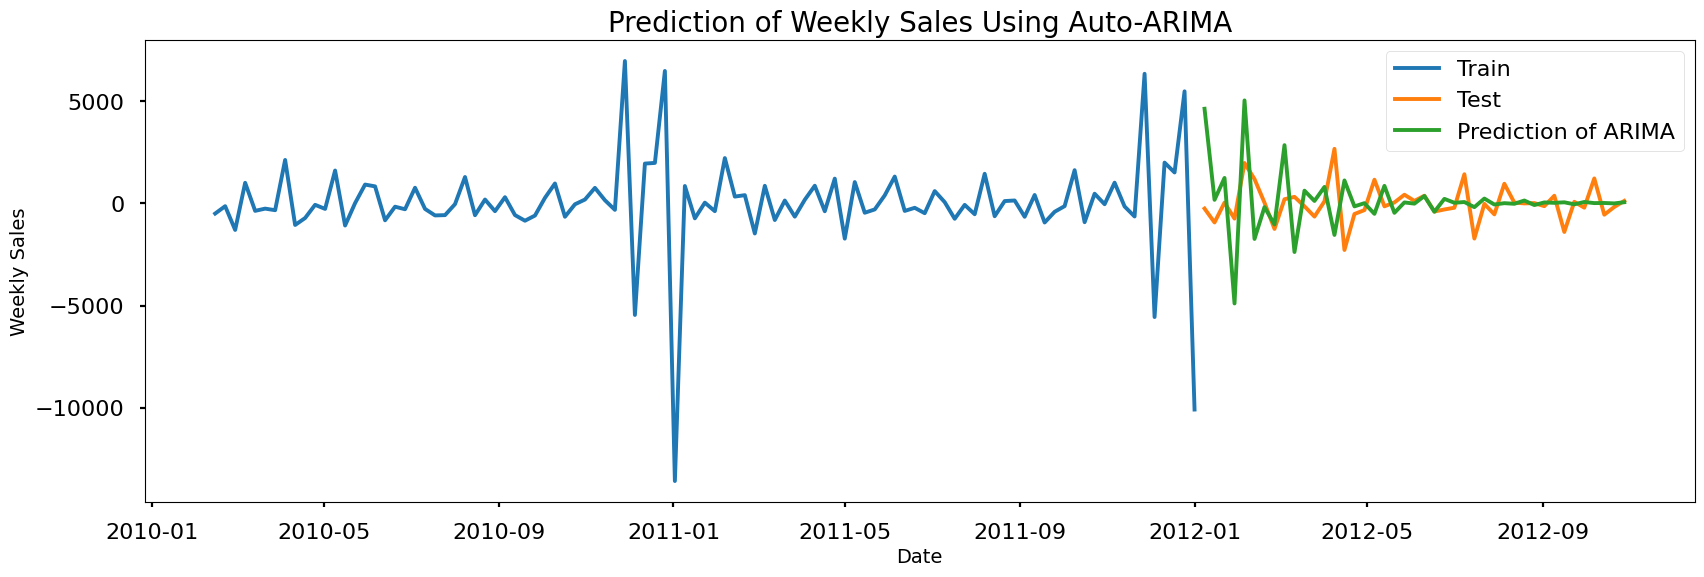

In [426]:
y_pred = model_auto_arima.predict(n_periods=len(test_data_diff))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

## ExponentialSmoothing

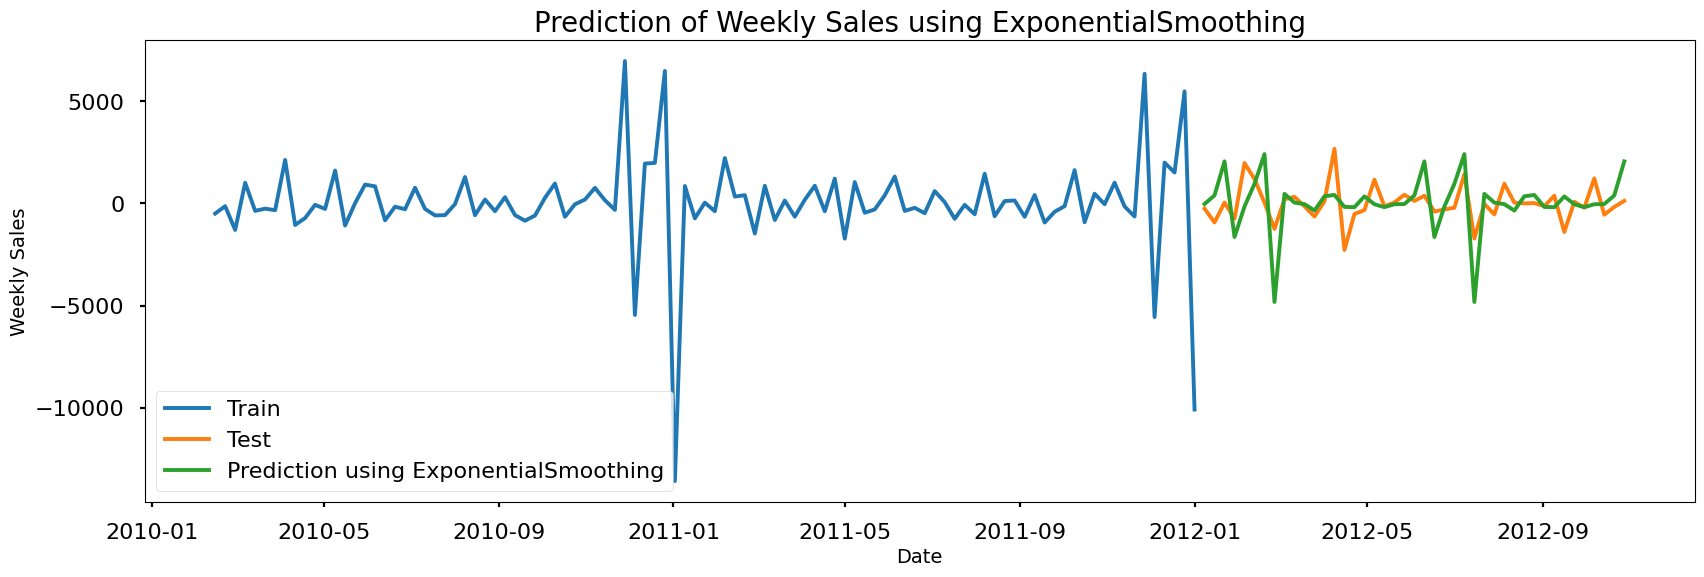

In [427]:
model_holt_winters = ExponentialSmoothing(train_data_diff, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() #Taking additive trend and seasonality.
y_pred = model_holt_winters.forecast(len(test_data_diff))# Predict the test data

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data_diff, label='Train')
plt.plot(test_data_diff, label='Test')
plt.plot(y_pred, label='Prediction using ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()